## Import Package

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import pickle
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_auc_score, RocCurveDisplay
)
from sklearn.preprocessing import LabelBinarizer
import missingno as msno
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import math

## Data Generating Process

In [2]:
# np.random.seed(42)

# # --- Settings ---
# n_samples = 14600
# ore_types = ['Sulphide', 'Oxide', 'Mixed']

# nan_fraction = 0.05
# outlier_fraction = 0.03
# duplicate_fraction = 0.03
# noise_scale = 0.15
# random_perturb_fraction = 0.15

# numeric_features = ['depth_mean','fe_pct','cu_pct','sio2_pct','moisture_pct','au_gpt']

# # --- Helper function ---
# def sample_with_noise_overlap(low, high, overlap_low=None, overlap_high=None, noise_scale=noise_scale):
#     val = np.random.uniform(low, high)
#     noise = np.random.normal(0, (high - low) * noise_scale)
#     val += noise
#     if overlap_low is not None and overlap_high is not None:
#         val += np.random.uniform(overlap_low, overlap_high)
#     return val

# # --- Generate ore types ---
# ore_type_label = np.random.choice(ore_types, n_samples)
# dataset = pd.DataFrame({'ore_type_label': ore_type_label})

# # --- Conditional sampling ---
# dataset['depth_mean'] = [
#     sample_with_noise_overlap(20,50,-5,5) if t=='Sulphide' else
#     sample_with_noise_overlap(0,25,-5,5) if t=='Oxide' else
#     sample_with_noise_overlap(10,40,-5,5)
#     for t in ore_type_label
# ]

# dataset['fe_pct'] = [
#     sample_with_noise_overlap(45,60,-5,5) if t=='Sulphide' else
#     sample_with_noise_overlap(20,40,-5,5) if t=='Oxide' else
#     sample_with_noise_overlap(30,55,-5,5)
#     for t in ore_type_label
# ]

# dataset['cu_pct'] = [
#     sample_with_noise_overlap(1.0,1.5,-0.2,0.2) if t=='Sulphide' else
#     sample_with_noise_overlap(0.3,0.8,-0.2,0.2) if t=='Oxide' else
#     sample_with_noise_overlap(0.5,1.2,-0.2,0.2)
#     for t in ore_type_label
# ]

# dataset['sio2_pct'] = [
#     sample_with_noise_overlap(0,2,-0.5,0.5) if t=='Sulphide' else
#     sample_with_noise_overlap(3,5,-0.5,0.5) if t=='Oxide' else
#     sample_with_noise_overlap(1,4,-0.5,0.5)
#     for t in ore_type_label
# ]

# dataset['moisture_pct'] = [
#     sample_with_noise_overlap(0,1,-0.3,0.3) if t=='Sulphide' else
#     sample_with_noise_overlap(1,3,-0.3,0.3) if t=='Oxide' else
#     sample_with_noise_overlap(0.5,2,-0.3,0.3)
#     for t in ore_type_label
# ]

# dataset['au_gpt'] = [
#     sample_with_noise_overlap(1,2,-0.3,0.3) if t=='Sulphide' else
#     sample_with_noise_overlap(0,0.5,-0.3,0.3) if t=='Oxide' else
#     sample_with_noise_overlap(0.3,1.2,-0.3,0.3)
#     for t in ore_type_label
# ]

# # --- Random pit assignment and sample_id ---
# dataset['pit'] = np.random.choice(['PitA','PitB','PitC'], n_samples)
# dataset['sample_id'] = [f'S{i:04d}' for i in range(n_samples)]

# # --- Introduce NaN values ---
# for col in numeric_features:
#     nan_indices = np.random.choice(dataset.index, size=int(n_samples*nan_fraction), replace=False)
#     dataset.loc[nan_indices, col] = np.nan

# # --- Introduce outliers ---
# feature_scales = {'depth_mean':100, 'fe_pct':200, 'cu_pct':5, 'sio2_pct':20, 'moisture_pct':10, 'au_gpt':10}
# for col, scale in feature_scales.items():
#     outlier_indices = np.random.choice(dataset.index, size=int(n_samples*outlier_fraction), replace=False)
#     dataset.loc[outlier_indices, col] += np.random.uniform(scale, scale*2, len(outlier_indices))

# # --- Random perturbation ---
# perturb_indices = np.random.choice(dataset.index, size=int(n_samples*random_perturb_fraction), replace=False)
# for col in numeric_features:
#     val_range = dataset[col].max() - dataset[col].min()
#     dataset.loc[perturb_indices, col] += np.random.uniform(-0.3*val_range, 0.3*val_range, len(perturb_indices))

# # --- Duplicated rows ---
# dup_indices = np.random.choice(dataset.index, size=int(n_samples*duplicate_fraction), replace=False)
# dataset = pd.concat([dataset, dataset.loc[dup_indices]], ignore_index=True)

# # --- Clip negative values to zero ---
# dataset[numeric_features] = dataset[numeric_features].clip(lower=0)

# # --- Shuffle dataset ---
# dataset = dataset.sample(frac=1, random_state=42).reset_index(drop=True)

# # --- Data Cleaning: Ensure No Negative or Unrealistic Values ---
# for col in numeric_features:
#     # Set negatif jadi NaN (lebih aman untuk imputasi selanjutnya)
#     dataset.loc[dataset[col] < 0, col] = np.nan

# # Batasi Fe_pct maksimal 100%
# dataset.loc[dataset['fe_pct'] > 100, 'fe_pct'] = 92.0  # Batas wajar Fe maksimal

# # Jika ada kolom persen lain, batasi juga secara wajar
# for col in ['moisture_pct', 'sio2_pct']:
#     dataset.loc[dataset[col] > 100, col] = 100

# # Jika ada nilai ekstrem untuk gold (Au_gpt) yang tak realistis
# dataset.loc[dataset['au_gpt'] > 50, 'au_gpt'] = np.nan  # 50 g/t batas tinggi wajar
# dataset.loc[dataset['au_gpt'] < 0, 'au_gpt'] = np.nan

# # Re-shuffle setelah cleaning
# dataset = dataset.sample(frac=1, random_state=42).reset_index(drop=True)

# # --- Validasi akhir ---
# print("\n=== Validation Check ===")
# print("Negative values remaining per column:")
# print((dataset[numeric_features] < 0).sum())

# print("\nFe_pct > 100 count:", (dataset['fe_pct'] > 100).sum())
# print("\nDescribe after cleaning:")
# print(dataset[numeric_features].describe())

# # --- Preview ---
# dataset.sample(10)

# # --- Generate date column per 20 sample ---
# n_samples = len(dataset)
# samples_per_day = 20
# n_days = int(np.ceil(n_samples / samples_per_day))

# date_range = pd.date_range(start='2023-01-01', periods=n_days, freq='D')

# # Repeat each date for 20 samples
# dates = np.repeat(date_range, samples_per_day)

# # If dataset longer than dates (due to ceil), trim
# dates = dates[:n_samples]

# dataset['date'] = dates

# # Optional: sort by date for clarity
# dataset = dataset.sort_values(['date','pit','sample_id']).reset_index(drop=True)

# # Tandai weekend
# dataset['is_weekend'] = dataset['date'].dt.dayofweek >= 5  # 5=Saturday,6=Sunday

# # Tandai maintenance simulasi
# maintenance_dates = pd.to_datetime(['2023-02-15','2023-07-01','2023-12-25'])
# dataset['is_maintenance'] = dataset['date'].isin(maintenance_dates)

# def adjust_for_holiday(row):
#     if row['is_weekend'] or row['is_maintenance']:
#         # 20% chance ubah sulphide jadi oxide
#         if row['ore_type_label'] == 'Sulphide' and np.random.rand() < 0.2:
#             return 'Oxide'
#     return row['ore_type_label']

# dataset['ore_type_label'] = dataset.apply(adjust_for_holiday, axis=1)

# #dataset = dataset[dataset['date']<'2025-01-01'].head(100)
# dataset.head()

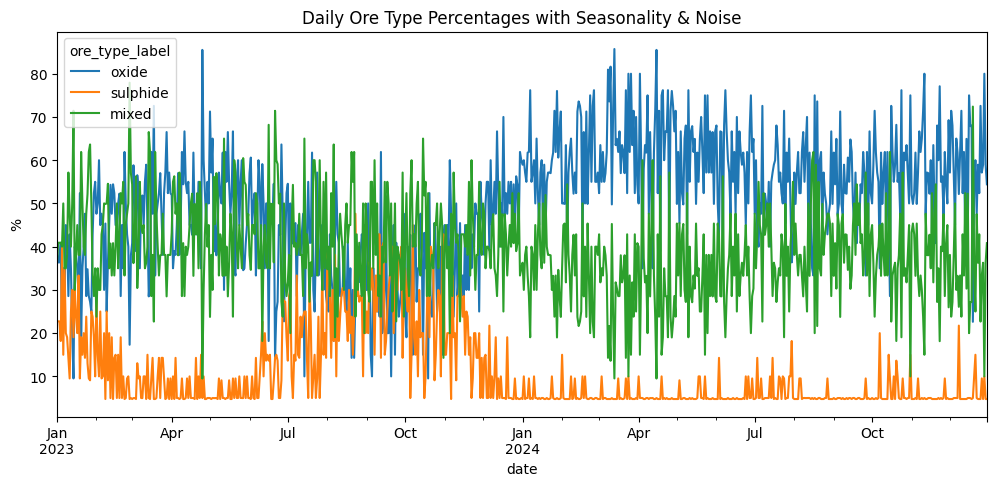

        date ore_type_label  depth_mean     fe_pct    cu_pct  sio2_pct  \
0 2023-01-01       Sulphide   20.804652  44.759414  0.524691  0.000000   
1 2023-01-01          Mixed   35.613600  45.669854  1.117368  2.775452   
2 2023-01-01          Mixed   36.554974  94.293082  0.948058  3.308067   
3 2023-01-01       Sulphide   45.471617  64.085705  1.204013  0.008778   
4 2023-01-01          Oxide   22.061671  43.768100  0.409945  3.999615   

   moisture_pct    au_gpt   pit sample_id  
0      0.261205  1.413724  PitC    S00000  
1      1.322770  0.953715  PitC    S00001  
2      3.330560  0.359391  PitC    S00002  
3      0.287777  1.498033  PitB    S00003  
4      3.464015  0.205175  PitA    S00004  
ore_type_label       date      oxide   sulphide      mixed
0              2023-01-01  40.909091  22.727273  36.363636
1              2023-01-02  36.363636  22.727273  40.909091
2              2023-01-03  36.363636  22.727273  40.909091
3              2023-01-04  40.909091  18.181818  40.909

In [3]:
np.random.seed(42)

# --- Settings ---
n_samples = 14600
samples_per_day = 20
n_days = int(np.ceil(n_samples / samples_per_day))
numeric_features = ['depth_mean','fe_pct','cu_pct','sio2_pct','moisture_pct','au_gpt']

nan_fraction = 0.05
outlier_fraction = 0.03
duplicate_fraction = 0.03
noise_scale = 0.15
random_perturb_fraction = 0.15
min_prob = 0.05  # ensure no zero probability

# --- Generate dates ---
date_range = pd.date_range(start='2023-01-01', periods=n_days, freq='D')
dates = np.repeat(date_range, samples_per_day)[:n_samples]

# --- Seasonal base probabilities for ore types ---
days = (pd.Series(date_range) - pd.Series(date_range).min()).dt.days.values
season_strength = 0.25
trend_strength = 0.001
daily_noise = 0.05

oxide_base = 0.4 + season_strength * np.sin(2 * np.pi * days / 365)
sulphide_base = 0.4 + season_strength * np.sin(2 * np.pi * days / 365 + math.pi)
mixed_base = 1.0 - (oxide_base + sulphide_base)/2

# Trend
oxide_base += trend_strength * days
sulphide_base -= trend_strength * days

# Repeat for each sample
oxide_rep = np.repeat(oxide_base, samples_per_day)[:n_samples]
sulphide_rep = np.repeat(sulphide_base, samples_per_day)[:n_samples]
mixed_rep = np.repeat(mixed_base, samples_per_day)[:n_samples]

# Add noise
rng = np.random.default_rng(42)
oxide_rep += rng.normal(0, daily_noise, n_samples)
sulphide_rep += rng.normal(0, daily_noise, n_samples)
mixed_rep += rng.normal(0, daily_noise, n_samples)

# Enforce minimum probability and normalize
probs = np.vstack([oxide_rep, sulphide_rep, mixed_rep]).T
probs = np.clip(probs, min_prob, None)
probs /= probs.sum(axis=1)[:, None]

# --- Assign ore types ---
ore_types = ['Oxide','Sulphide','Mixed']
ore_labels = [np.random.choice(ore_types, p=p) for p in probs]

# --- Initialize dataset ---
dataset = pd.DataFrame({
    'date': dates,
    'ore_type_label': ore_labels
})

# --- Helper function for numeric features ---
def sample_with_noise_overlap(low, high, overlap_low=None, overlap_high=None, noise_scale=noise_scale):
    val = np.random.uniform(low, high)
    noise = np.random.normal(0, (high - low) * noise_scale)
    val += noise
    if overlap_low is not None and overlap_high is not None:
        val += np.random.uniform(overlap_low, overlap_high)
    return val

# --- Generate numeric features per ore type ---
for feat in numeric_features:
    vals = []
    for t in dataset['ore_type_label']:
        if feat == 'depth_mean':
            vals.append(sample_with_noise_overlap(20,50,-5,5) if t=='Sulphide' else
                        sample_with_noise_overlap(0,25,-5,5) if t=='Oxide' else
                        sample_with_noise_overlap(10,40,-5,5))
        elif feat == 'fe_pct':
            vals.append(sample_with_noise_overlap(45,60,-5,5) if t=='Sulphide' else
                        sample_with_noise_overlap(20,40,-5,5) if t=='Oxide' else
                        sample_with_noise_overlap(30,55,-5,5))
        elif feat == 'cu_pct':
            vals.append(sample_with_noise_overlap(1.0,1.5,-0.2,0.2) if t=='Sulphide' else
                        sample_with_noise_overlap(0.3,0.8,-0.2,0.2) if t=='Oxide' else
                        sample_with_noise_overlap(0.5,1.2,-0.2,0.2))
        elif feat == 'sio2_pct':
            vals.append(sample_with_noise_overlap(0,2,-0.5,0.5) if t=='Sulphide' else
                        sample_with_noise_overlap(3,5,-0.5,0.5) if t=='Oxide' else
                        sample_with_noise_overlap(1,4,-0.5,0.5))
        elif feat == 'moisture_pct':
            vals.append(sample_with_noise_overlap(0,1,-0.3,0.3) if t=='Sulphide' else
                        sample_with_noise_overlap(1,3,-0.3,0.3) if t=='Oxide' else
                        sample_with_noise_overlap(0.5,2,-0.3,0.3))
        elif feat == 'au_gpt':
            vals.append(sample_with_noise_overlap(1,2,-0.3,0.3) if t=='Sulphide' else
                        sample_with_noise_overlap(0,0.5,-0.3,0.3) if t=='Oxide' else
                        sample_with_noise_overlap(0.3,1.2,-0.3,0.3))
    dataset[feat] = vals

# --- Introduce NaNs, outliers, random perturbation, duplicates ---
for col in numeric_features:
    # NaNs
    nan_indices = np.random.choice(dataset.index, size=int(n_samples*nan_fraction), replace=False)
    dataset.loc[nan_indices, col] = np.nan
    # Outliers
    scale = 1.5*dataset[col].mean()
    outlier_indices = np.random.choice(dataset.index, size=int(n_samples*outlier_fraction), replace=False)
    dataset.loc[outlier_indices, col] += np.random.uniform(scale, scale*2, len(outlier_indices))
    # Random perturbation
    perturb_indices = np.random.choice(dataset.index, size=int(n_samples*random_perturb_fraction), replace=False)
    val_range = dataset[col].max() - dataset[col].min()
    dataset.loc[perturb_indices, col] += np.random.uniform(-0.3*val_range,0.3*val_range,len(perturb_indices))

# --- Duplicates ---
dup_indices = np.random.choice(dataset.index, size=int(n_samples*duplicate_fraction), replace=False)
dataset = pd.concat([dataset, dataset.loc[dup_indices]], ignore_index=True)

# --- Clip numeric values to reasonable ranges ---
dataset[numeric_features] = dataset[numeric_features].clip(lower=0)

# --- Add pit and sample_id ---
dataset['pit'] = np.random.choice(['PitA','PitB','PitC'], len(dataset))
dataset['sample_id'] = [f"S{i:05d}" for i in range(len(dataset))]

# --- Aggregate to daily percentages for Prophet ---
counts_per_day = dataset.groupby(['date','ore_type_label']).size().unstack(fill_value=0)
for cls in ore_types:
    if cls not in counts_per_day.columns:
        counts_per_day[cls] = 0
counts_per_day = counts_per_day[ore_types]
pct_per_day = counts_per_day.div(counts_per_day.sum(axis=1), axis=0) * 100
pct_per_day = pct_per_day.reset_index()
pct_per_day.rename(columns=lambda c: c.lower(), inplace=True)

# --- Ensure no zeros ---
pct_per_day[['oxide','sulphide','mixed']] = pct_per_day[['oxide','sulphide','mixed']].clip(lower=min_prob*100)
pct_per_day[['oxide','sulphide','mixed']] = pct_per_day[['oxide','sulphide','mixed']].div(
    pct_per_day[['oxide','sulphide','mixed']].sum(axis=1), axis=0)*100

# --- Plot ---
pct_per_day.plot(x='date', y=['oxide','sulphide','mixed'], figsize=(12,5))
plt.title("Daily Ore Type Percentages with Seasonality & Noise")
plt.ylabel("%")
plt.show()

# --- Preview ---
print(dataset.head())
print(pct_per_day.head())


In [ ]:
dataset.to_csv('ore_type_data.csv', index=False)

In [ ]:
dataset = pd.read_csv('data/ore_type_data.csv', parse_dates=['date'])

## Exploratory Data Analysis

Train shape: (12030, 10), Test shape: (3008, 10)
Train ore type distribution:
ore_type_label
Oxide       0.510141
Mixed       0.396259
Sulphide    0.093599
Name: proportion, dtype: float64

=== Train Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
Index: 12030 entries, 14307 to 5779
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            12030 non-null  datetime64[ns]
 1   ore_type_label  12030 non-null  object        
 2   depth_mean      11419 non-null  float64       
 3   fe_pct          11417 non-null  float64       
 4   cu_pct          11468 non-null  float64       
 5   sio2_pct        11435 non-null  float64       
 6   moisture_pct    11452 non-null  float64       
 7   au_gpt          11436 non-null  float64       
 8   pit             12030 non-null  object        
 9   sample_id       12030 non-null  object        
dtypes: datetime64[ns](1), float64(6), object(3)
mem

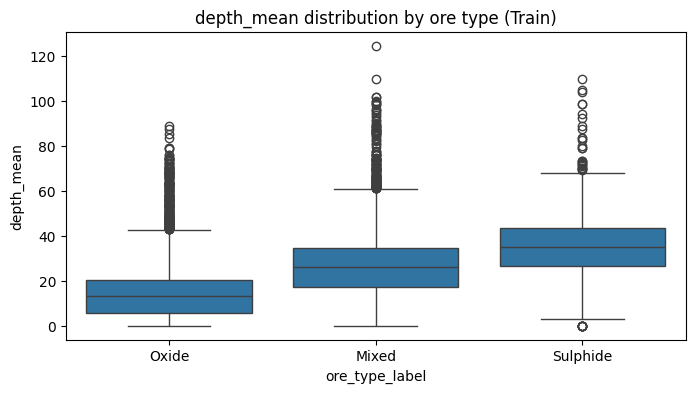

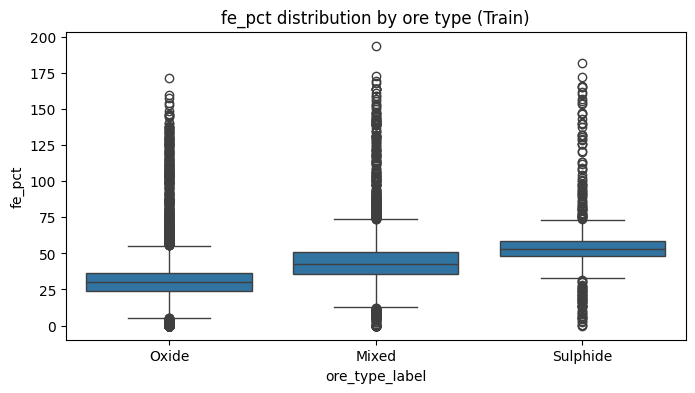

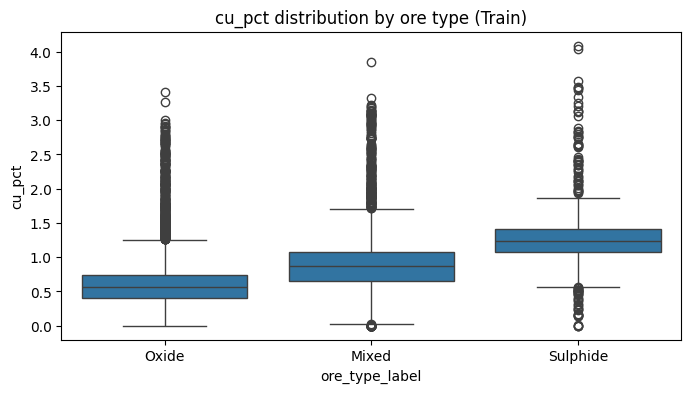

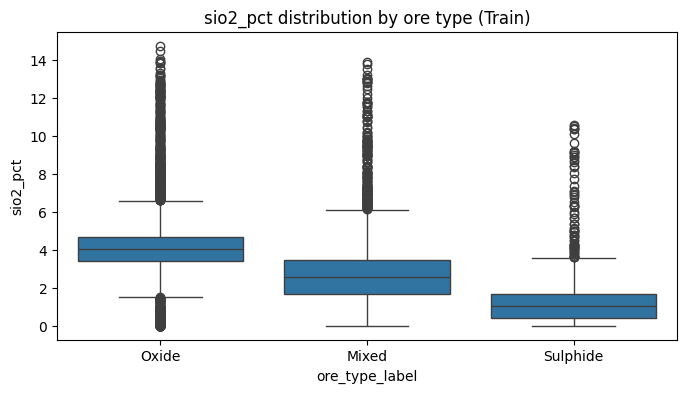

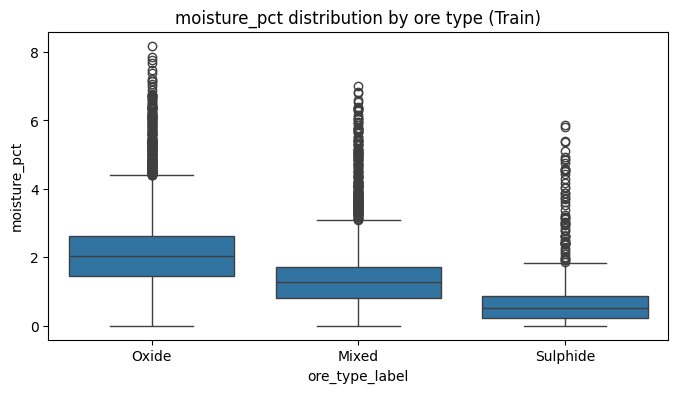

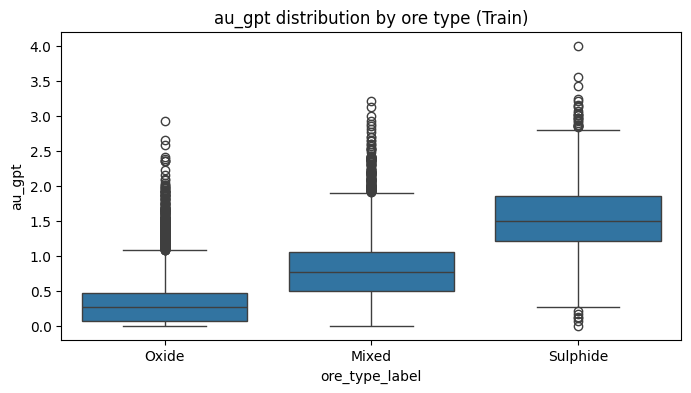

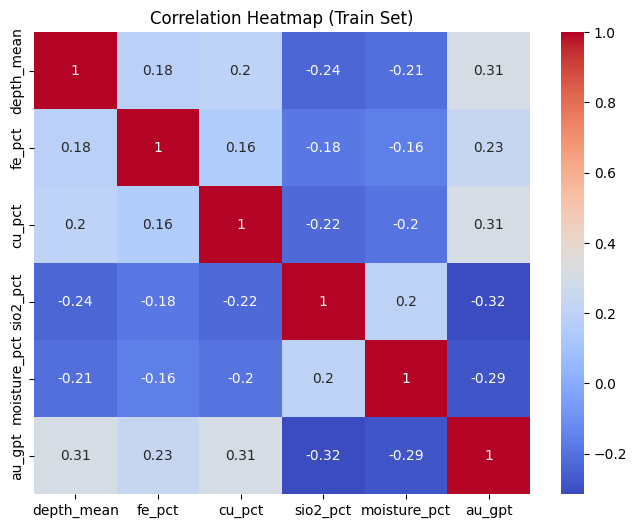


=== Missing Values (Train Set) ===
date                0
ore_type_label      0
depth_mean        611
fe_pct            613
cu_pct            562
sio2_pct          595
moisture_pct      578
au_gpt            594
pit                 0
sample_id           0
dtype: int64

Number of duplicate rows in train set: 0


In [4]:
# =========================
# 0. Train/Test Split
# =========================

# Use stratify on ore_type_label to maintain class distribution

train_df, test_df = train_test_split(
                    dataset, test_size=0.2, random_state=42, stratify=dataset['ore_type_label']
                    )

print(f"Train shape: {train_df.shape}, Test shape: {test_df.shape}")
print("Train ore type distribution:")
print(train_df['ore_type_label'].value_counts(normalize=True))

# =========================
# 1. EDA on Train Set
# =========================

print("\n=== Train Dataset Info ===")
train_df.info()

print("\n=== Train Dataset Description ===")
train_df.describe(include='all')

print("\n=== Ore type counts (Train) ===")
train_df['ore_type_label'].value_counts()

# Visualisasi distribusi numeric features per ore type
numeric_features = ['depth_mean','fe_pct','cu_pct','sio2_pct','moisture_pct','au_gpt']

for col in numeric_features:
    plt.figure(figsize=(8,4))
    sns.boxplot(x='ore_type_label', y=col, data=train_df)
    plt.title(f'{col} distribution by ore type (Train)')
    plt.show()

# Correlation heatmap for numeric features in train set
plt.figure(figsize=(8,6))
sns.heatmap(train_df[numeric_features].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap (Train Set)')
plt.show()

# Check missing values in train set
print("\n=== Missing Values (Train Set) ===")
print(train_df.isna().sum())

# Check duplicates in train set
n_duplicates_train = train_df.duplicated().sum()
print(f"\nNumber of duplicate rows in train set: {n_duplicates_train}")


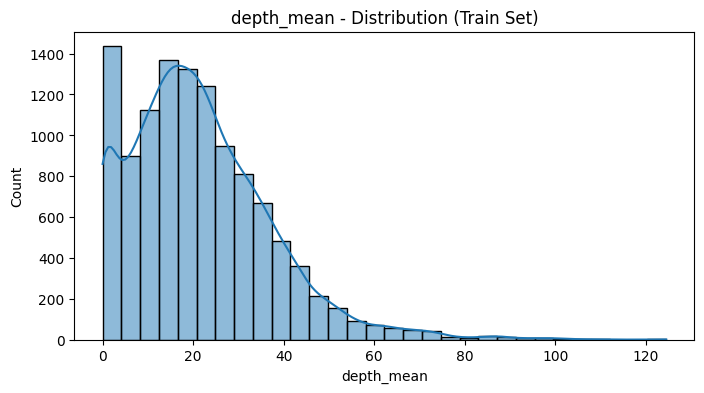

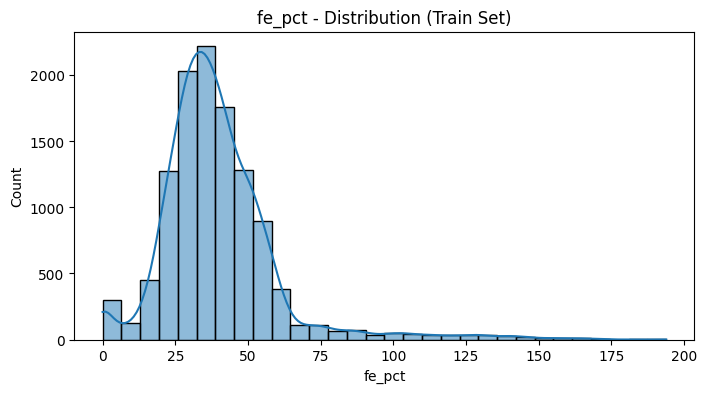

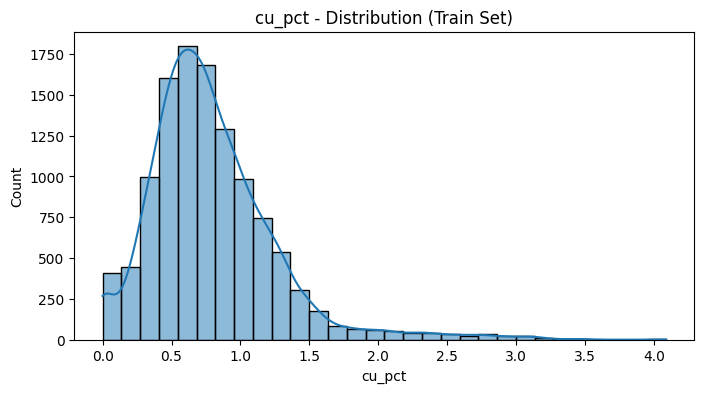

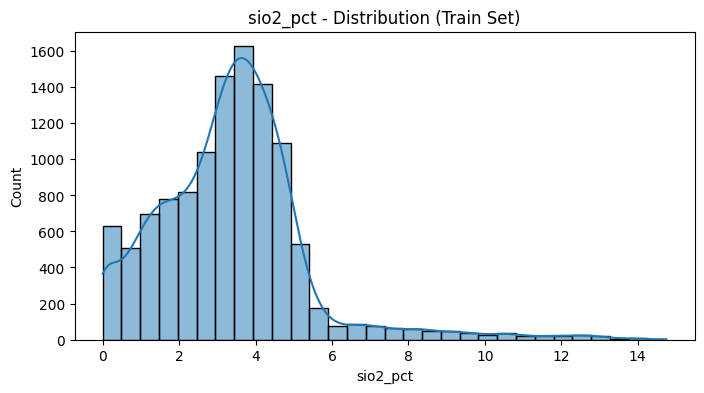

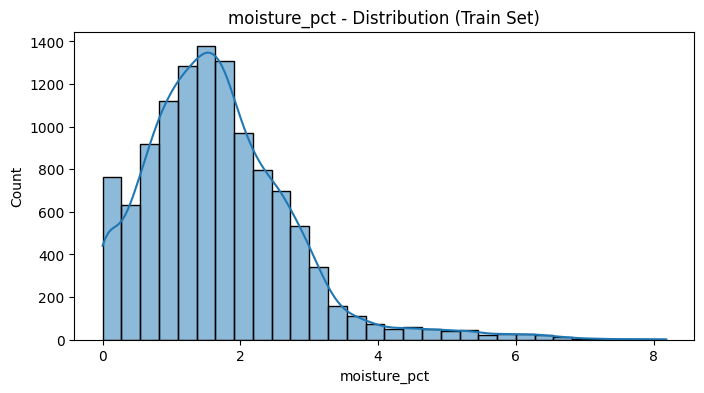

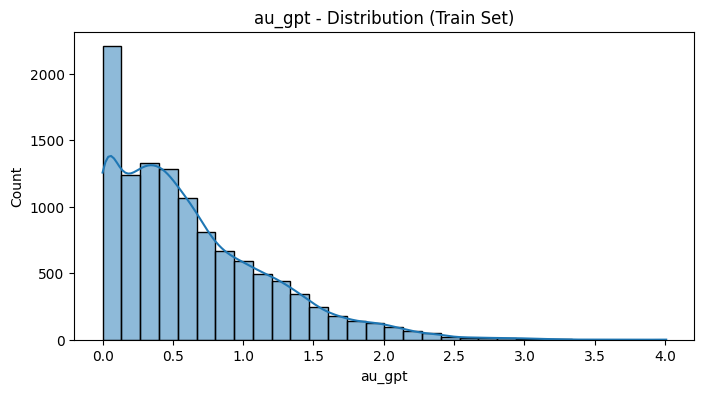


=== Outlier Counts per Feature ===
        Feature  Outlier_Count
1        fe_pct            512
2        cu_pct            430
3      sio2_pct            412
4  moisture_pct            344
5        au_gpt            276
0    depth_mean            267


In [5]:
# Distribution plots for numerical features
for col in numeric_features:
    plt.figure(figsize=(8,4))
    sns.histplot(train_df[col], kde=True, bins=30)
    plt.title(f'{col} - Distribution (Train Set)')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

# Outlier detection using IQR
outlier_summary = {}
for col in numeric_features:
    Q1 = train_df[col].quantile(0.25)
    Q3 = train_df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = train_df[(train_df[col] < (Q1 - 1.5 * IQR)) | (train_df[col] > (Q3 + 1.5 * IQR))]
    outlier_summary[col] = len(outliers)
outlier_df = pd.DataFrame(list(outlier_summary.items()), columns=['Feature', 'Outlier_Count'])
print("\n=== Outlier Counts per Feature ===")
print(outlier_df.sort_values(by='Outlier_Count', ascending=False))


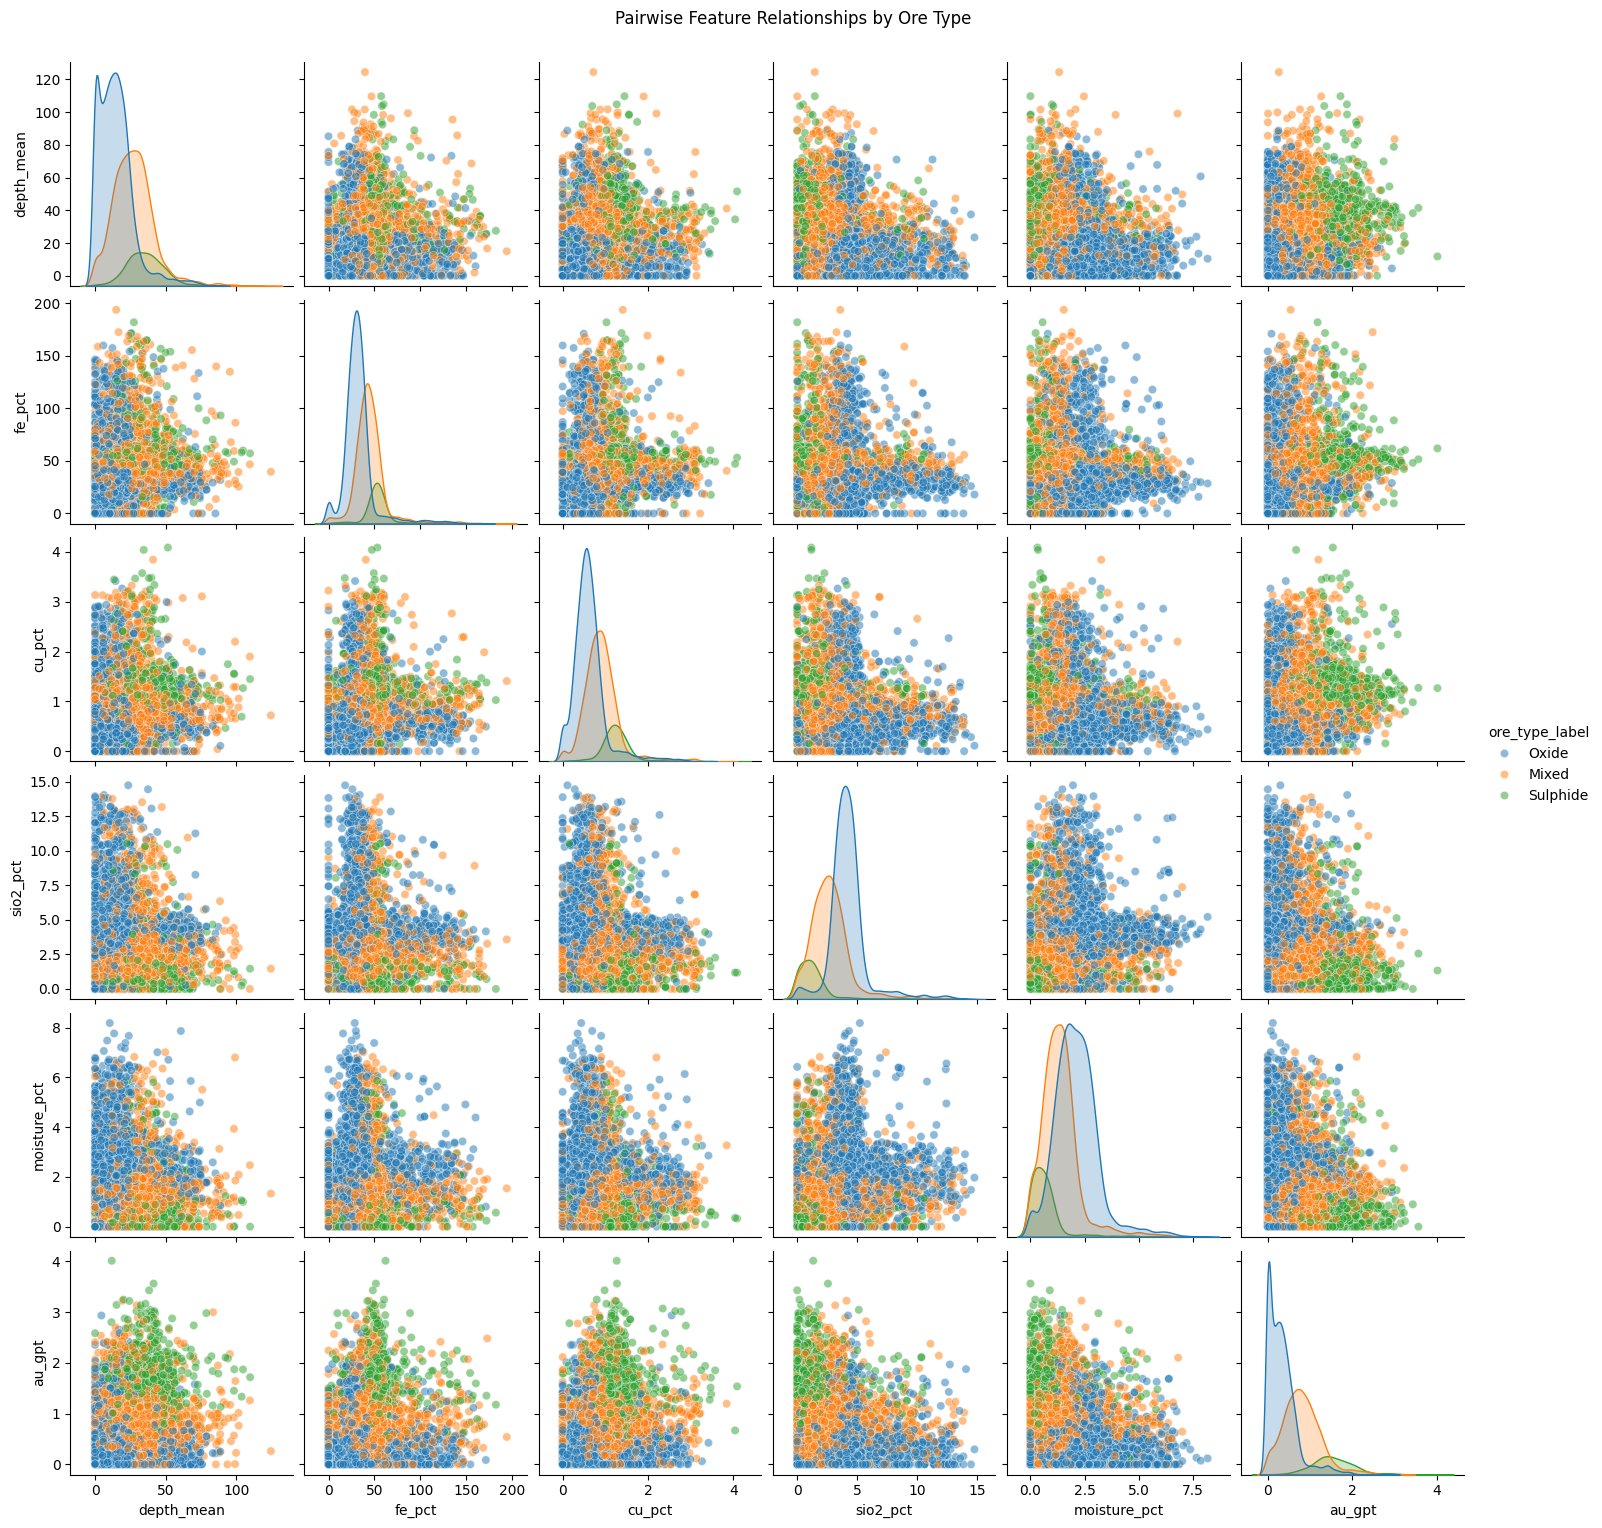


=== Highly Correlated Feature Pairs (>0.8) ===
sio2_pct      au_gpt          0.315505
depth_mean    au_gpt          0.306892
cu_pct        au_gpt          0.306847
moisture_pct  au_gpt          0.285071
depth_mean    sio2_pct        0.235592
fe_pct        au_gpt          0.234949
cu_pct        sio2_pct        0.223485
depth_mean    moisture_pct    0.211090
              cu_pct          0.203596
sio2_pct      moisture_pct    0.201024
cu_pct        moisture_pct    0.196777
depth_mean    fe_pct          0.184436
fe_pct        sio2_pct        0.176913
              moisture_pct    0.157224
              cu_pct          0.156676
dtype: float64


In [6]:
# Pairplot by ore type
sns.pairplot(train_df, vars=numeric_features, hue='ore_type_label', diag_kind='kde', plot_kws={'alpha':0.5})
plt.suptitle('Pairwise Feature Relationships by Ore Type', y=1.02)
plt.show()

# Correlation ranking
corr_matrix = train_df[numeric_features].corr().abs()
high_corr = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
print("\n=== Highly Correlated Feature Pairs (>0.8) ===")
print(high_corr.stack().sort_values(ascending=False))

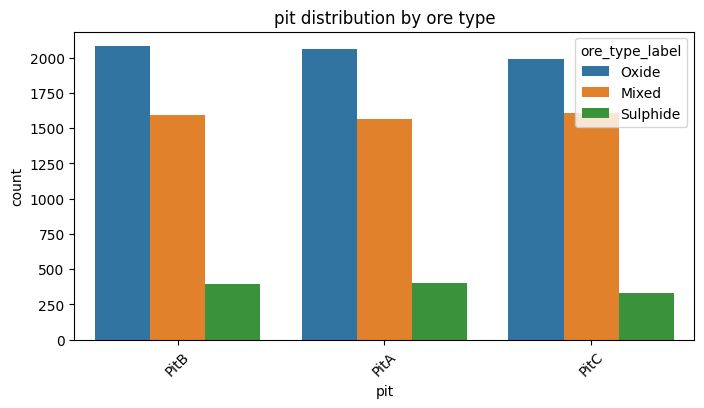

In [7]:
# Categorical feature distribution
categorical_features = ['pit']
for col in categorical_features:
    if col in train_df.columns:
        plt.figure(figsize=(8,4))
        sns.countplot(x=col, hue='ore_type_label', data=train_df)
        plt.title(f'{col} distribution by ore type')
        plt.xticks(rotation=45)
        plt.show()

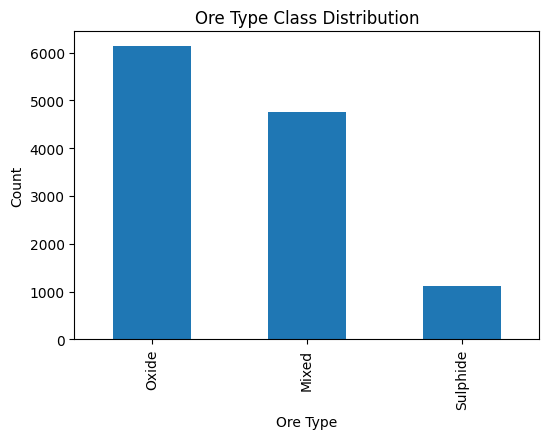

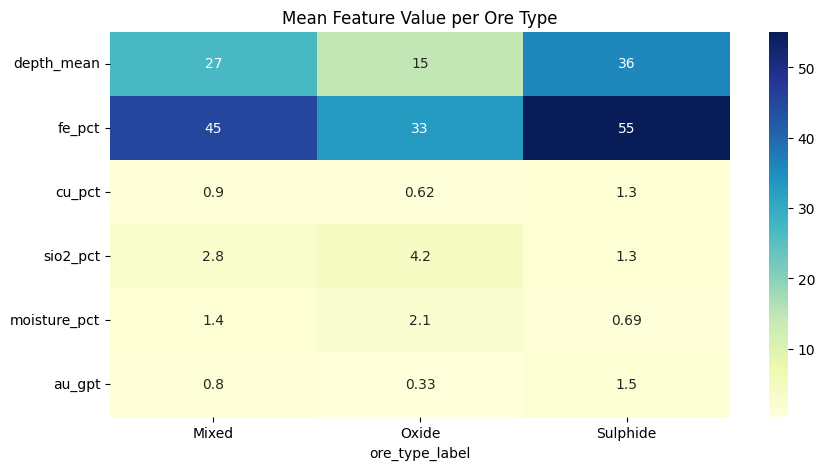


=== ANOVA Feature Importance (NaN handled by mean imputation) ===
        Feature      F_value  p_value  Significant
5        au_gpt  4338.553906      0.0         True
0    depth_mean  1716.011261      0.0         True
3      sio2_pct  1673.618589      0.0         True
4  moisture_pct  1363.773652      0.0         True
2        cu_pct  1355.996603      0.0         True
1        fe_pct   898.915389      0.0         True


In [8]:
# Class balance
plt.figure(figsize=(6,4))
train_df['ore_type_label'].value_counts().plot(kind='bar')
plt.title('Ore Type Class Distribution')
plt.xlabel('Ore Type')
plt.ylabel('Count')
plt.show()

# Mean feature value per class
mean_per_class = train_df.groupby('ore_type_label')[numeric_features].mean().T
plt.figure(figsize=(10,5))
sns.heatmap(mean_per_class, annot=True, cmap='YlGnBu')
plt.title('Mean Feature Value per Ore Type')
plt.show()

# Feature importance proxy via ANOVA F-value
from sklearn.feature_selection import f_classif
# Handle NaN sebelum ANOVA dengan imputasi sederhana
X_anova = train_df[numeric_features].copy()
X_anova = X_anova.fillna(X_anova.mean())

f_values, p_values = f_classif(X_anova, train_df['ore_type_label'])
anova_df = pd.DataFrame({
    'Feature': numeric_features,
    'F_value': f_values,
    'p_value': p_values
})
anova_df['Significant'] = anova_df['p_value'] < 0.05

print("\n=== ANOVA Feature Importance (NaN handled by mean imputation) ===")
print(anova_df.sort_values('F_value', ascending=False))

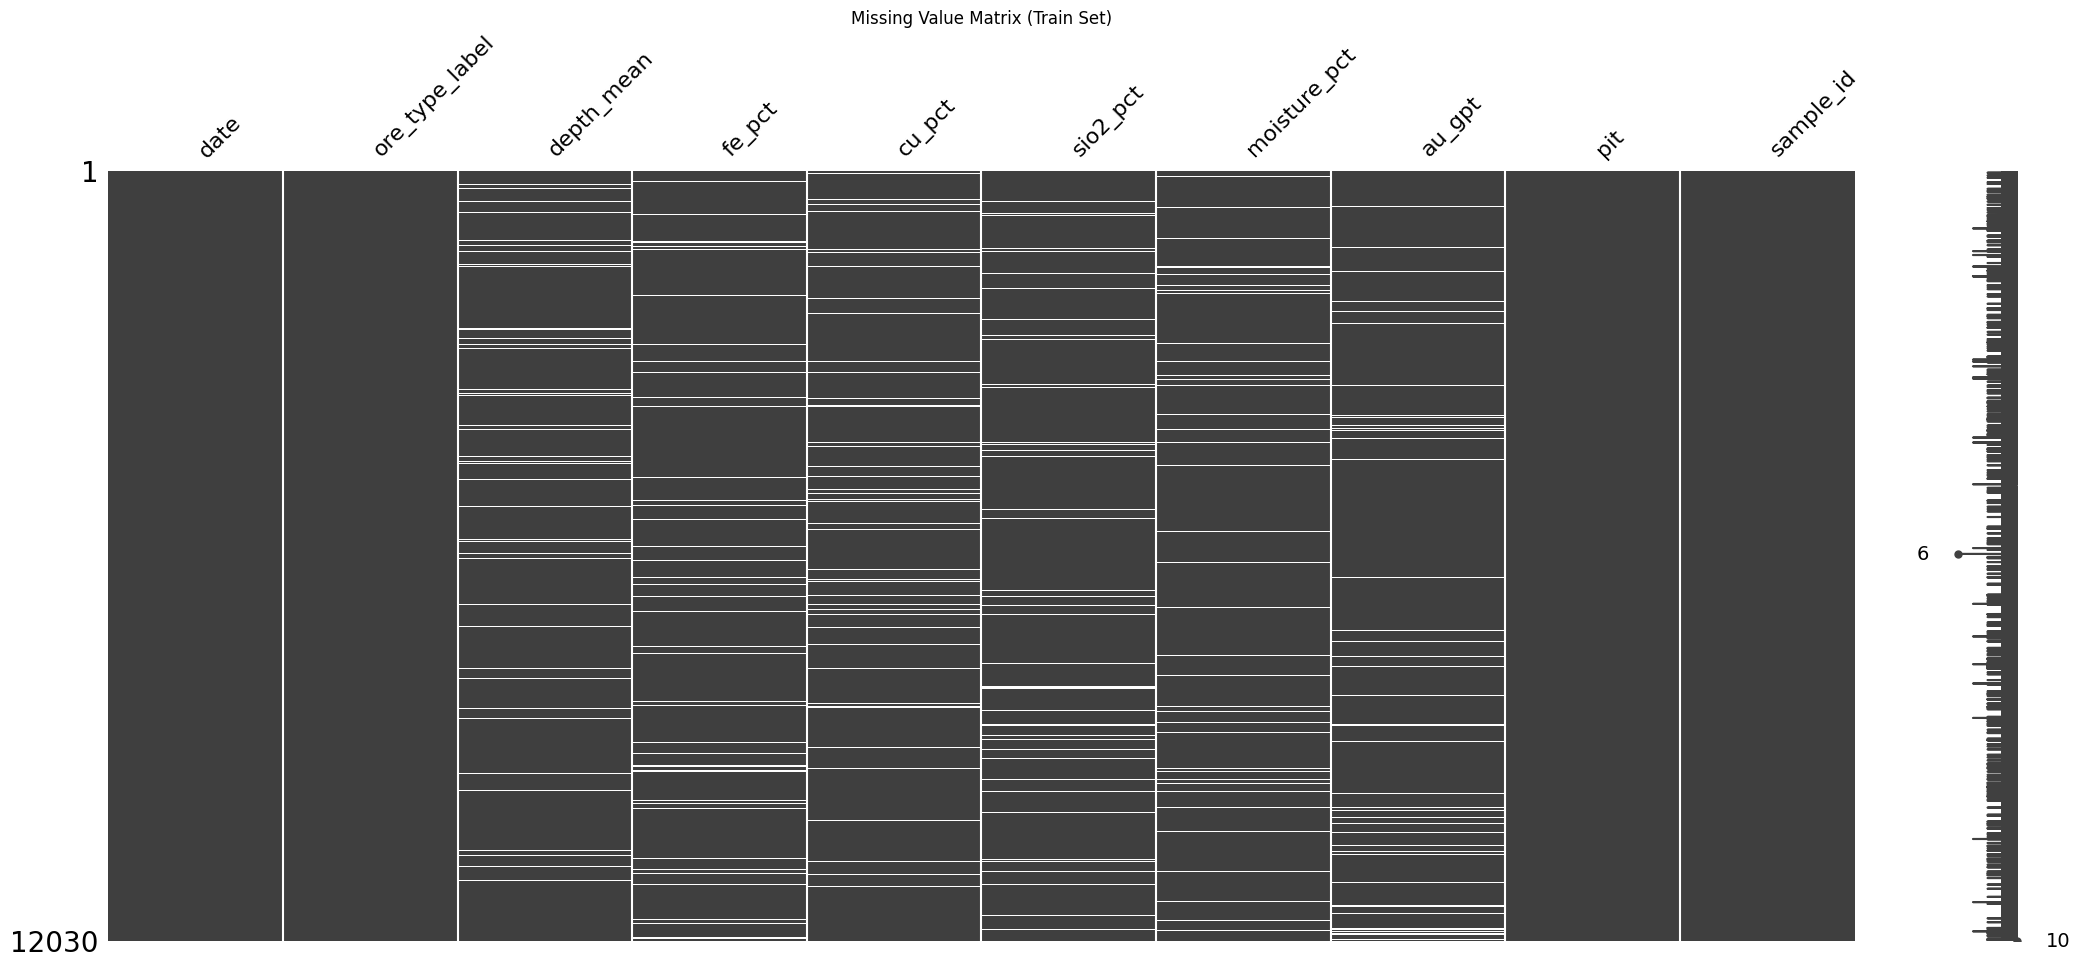

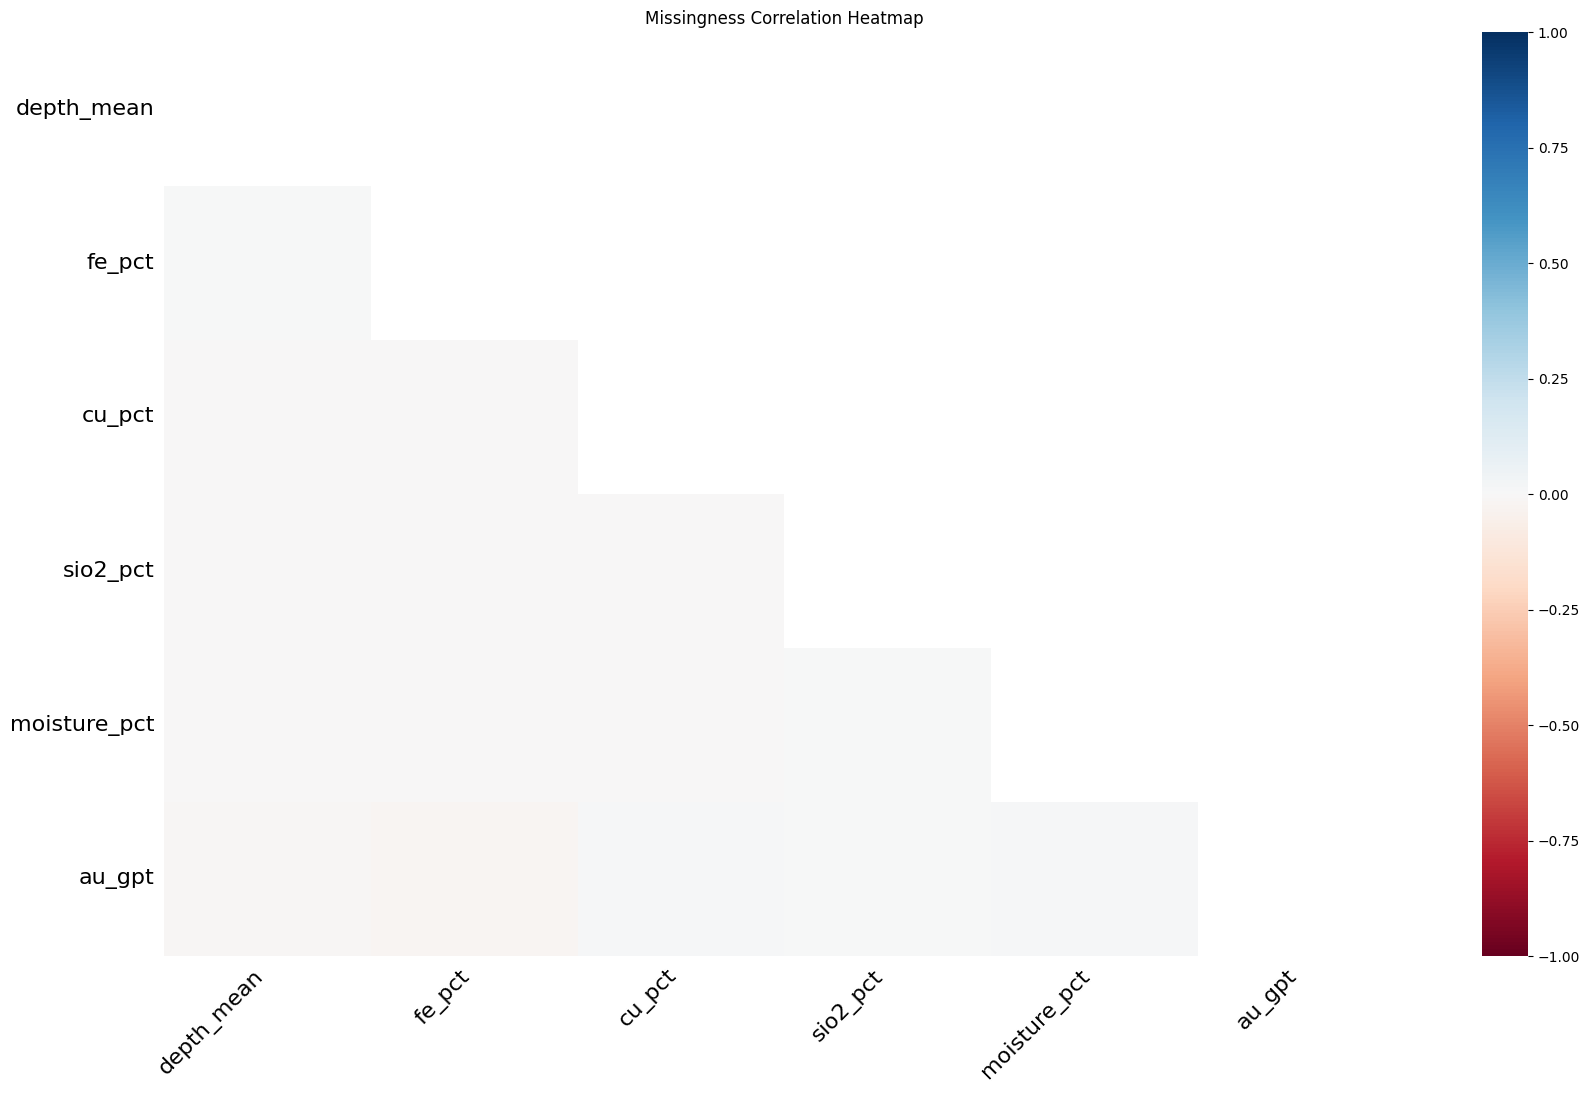

In [9]:
msno.matrix(train_df)
plt.title('Missing Value Matrix (Train Set)')
plt.show()

msno.heatmap(train_df)
plt.title('Missingness Correlation Heatmap')
plt.show()

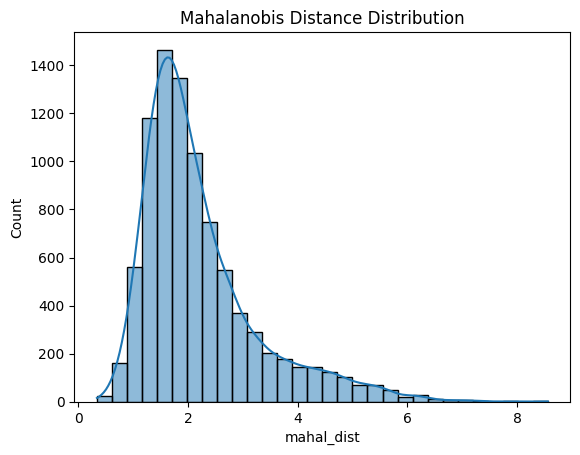


Potential Multivariate Outliers (>99th percentile): 89 samples


In [10]:
from scipy.spatial.distance import mahalanobis

X = train_df[numeric_features].dropna()
cov_matrix = np.cov(X.T)
inv_cov = np.linalg.inv(cov_matrix)
center = X.mean().values
mahal_dist = X.apply(lambda row: mahalanobis(row, center, inv_cov), axis=1)
train_df.loc[X.index, 'mahal_dist'] = mahal_dist

sns.histplot(train_df['mahal_dist'], bins=30, kde=True)
plt.title('Mahalanobis Distance Distribution')
plt.show()

# Threshold example (approx 99th percentile)
threshold = np.percentile(mahal_dist, 99)
potential_outliers = train_df[train_df['mahal_dist'] > threshold]
print(f"\nPotential Multivariate Outliers (>99th percentile): {len(potential_outliers)} samples")

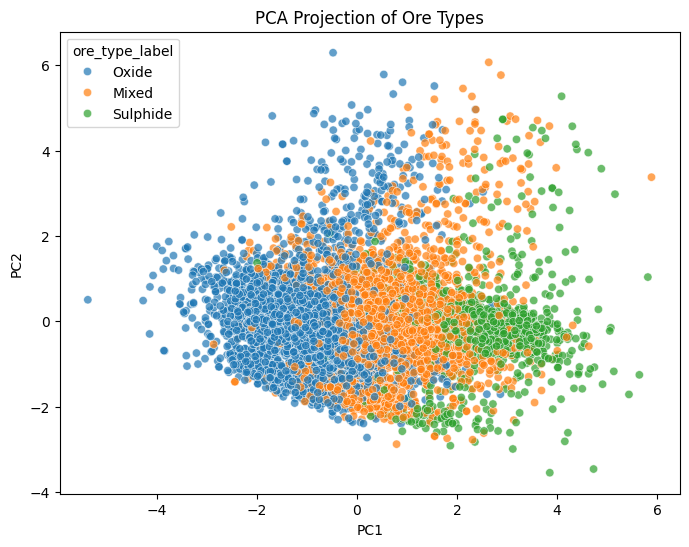

Explained variance ratio: 47.76%


In [11]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(train_df[numeric_features].fillna(0))
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['ore_type_label'] = train_df['ore_type_label'].values

plt.figure(figsize=(8,6))
sns.scatterplot(x='PC1', y='PC2', hue='ore_type_label', data=pca_df, alpha=0.7)
plt.title('PCA Projection of Ore Types')
plt.show()

print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum():.2%}")


## Data Preprocessing

In [12]:
# =========================
# 1. Drop duplicates in train set
# =========================
from sklearn.calibration import LabelEncoder

train_df = train_df.drop_duplicates().reset_index(drop=True)

# =========================
# 2. Separate features and target (train)
# =========================
X_train = train_df.drop(['sample_id', 'ore_type_label'], axis=1)
y_train = train_df['ore_type_label']

# =========================
# 3. Encode target
# =========================
target_encoder = LabelEncoder()
y_train_encoded = target_encoder.fit_transform(y_train)

print("\nTarget mapping (train set):")
for cls, code in zip(target_encoder.classes_, range(len(target_encoder.classes_))):
    print(f"{cls} -> {code}")

# =========================
# 4. Identify numeric and categorical columns
# =========================
numeric_cols = ['depth_mean', 'fe_pct', 'cu_pct', 'sio2_pct', 'moisture_pct', 'au_gpt']
categorical_cols = ['pit']

# =========================
# 5. Preprocessing pipeline for train set
# =========================
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

# Fit on train set only
X_train_preprocessed = preprocessor.fit_transform(X_train)
print(f"\nShape of preprocessed train features: {X_train_preprocessed.shape}")

# =========================
# 6. Convert to DataFrame for inspection
# =========================
ohe_cols = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)
all_cols = numeric_cols + list(ohe_cols)

X_train_df = pd.DataFrame(X_train_preprocessed, columns=all_cols)

print("\nPreprocessed train features preview:")
print(X_train_df.head())
print("\nEncoded target (train) preview:")
print(y_train_encoded[:10])

# =========================
# 7. Apply same preprocessing to test set
# =========================
X_test = test_df.drop(['sample_id', 'ore_type_label'], axis=1)
# encode using same encoder (IMPORTANT: only use transform, not fit_transform)
y_test = target_encoder.transform(test_df['ore_type_label'])
X_test_preprocessed = preprocessor.transform(X_test)

X_test_df = pd.DataFrame(X_test_preprocessed, columns=all_cols)
print(f"\nShape of preprocessed test features: {X_test_preprocessed.shape}")

print("\nEncoded target (test) preview:")
print(y_test[:10])


Target mapping (train set):
Mixed -> 0
Oxide -> 1
Sulphide -> 2

Shape of preprocessed train features: (12030, 9)

Preprocessed train features preview:
   depth_mean    fe_pct    cu_pct  sio2_pct  moisture_pct    au_gpt  pit_PitA  \
0   -1.408426 -0.152688  0.652811 -0.209138     -0.407655  1.632153       0.0   
1    1.167956 -0.054510 -0.375066  0.123669     -0.608773 -0.160961       1.0   
2    0.241109 -1.241046 -0.105410  0.005469      0.988583 -0.584640       1.0   
3   -0.129759  0.676374  0.687859 -1.306865     -1.589836  0.805670       0.0   
4    0.027840 -0.762777  0.078460 -0.033301      1.117118 -1.152494       1.0   

   pit_PitB  pit_PitC  
0       1.0       0.0  
1       0.0       0.0  
2       0.0       0.0  
3       1.0       0.0  
4       0.0       0.0  

Encoded target (train) preview:
[1 0 1 0 1 0 1 2 0 1]

Shape of preprocessed test features: (3008, 9)

Encoded target (test) preview:
[0 1 1 1 1 1 0 1 2 0]


## Modelling


EVALUASI MODEL: Random Forest

Confusion Matrix:
          Mixed  Oxide  Sulphide
Mixed      1041    137        14
Oxide       125   1409         0
Sulphide     72      0       210

Classification Report:
              precision    recall  f1-score   support

       Mixed       0.84      0.87      0.86      1192
       Oxide       0.91      0.92      0.91      1534
    Sulphide       0.94      0.74      0.83       282

    accuracy                           0.88      3008
   macro avg       0.90      0.85      0.87      3008
weighted avg       0.89      0.88      0.88      3008

ROC AUC Score (One-vs-Rest): 0.9724


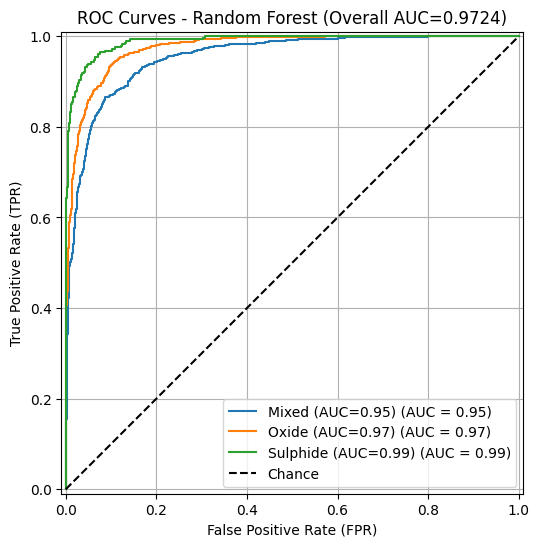


EVALUASI MODEL: Decision Tree

Confusion Matrix:
          Mixed  Oxide  Sulphide
Mixed      1002    160        30
Oxide       161   1373         0
Sulphide     76      2       204

Classification Report:
              precision    recall  f1-score   support

       Mixed       0.81      0.84      0.82      1192
       Oxide       0.89      0.90      0.89      1534
    Sulphide       0.87      0.72      0.79       282

    accuracy                           0.86      3008
   macro avg       0.86      0.82      0.84      3008
weighted avg       0.86      0.86      0.86      3008

ROC AUC Score (One-vs-Rest): 0.9031


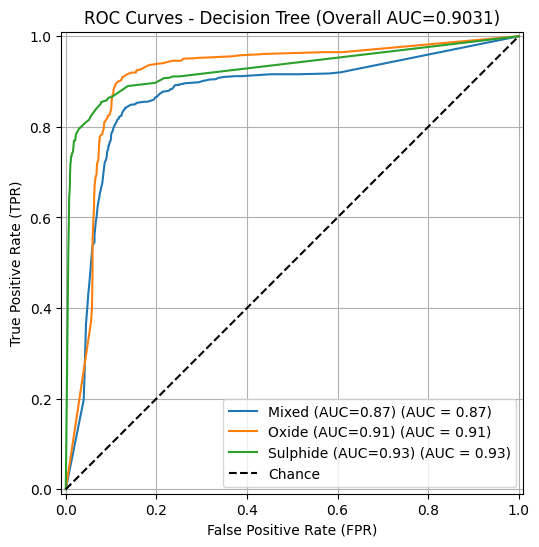


EVALUASI MODEL: Logistic Regression

Confusion Matrix:
          Mixed  Oxide  Sulphide
Mixed       898    278        16
Oxide       140   1393         1
Sulphide    152      2       128

Classification Report:
              precision    recall  f1-score   support

       Mixed       0.75      0.75      0.75      1192
       Oxide       0.83      0.91      0.87      1534
    Sulphide       0.88      0.45      0.60       282

    accuracy                           0.80      3008
   macro avg       0.82      0.71      0.74      3008
weighted avg       0.81      0.80      0.80      3008

ROC AUC Score (One-vs-Rest): 0.9203


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


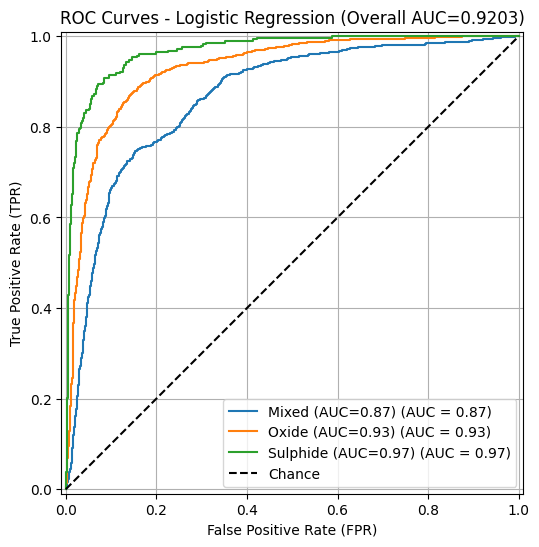


EVALUASI MODEL: KNN

Confusion Matrix:
          Mixed  Oxide  Sulphide
Mixed       998    155        39
Oxide       129   1405         0
Sulphide     69      0       213

Classification Report:
              precision    recall  f1-score   support

       Mixed       0.83      0.84      0.84      1192
       Oxide       0.90      0.92      0.91      1534
    Sulphide       0.85      0.76      0.80       282

    accuracy                           0.87      3008
   macro avg       0.86      0.84      0.85      3008
weighted avg       0.87      0.87      0.87      3008

ROC AUC Score (One-vs-Rest): 0.9400


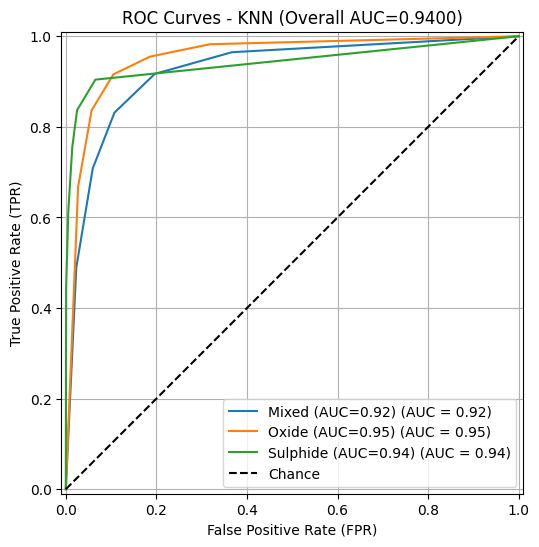

In [13]:
# List of models to evaluate
models = {
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10),
    'Logistic Regression': LogisticRegression(max_iter=1000, multi_class='ovr', solver='liblinear'),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

# Binarizer for multi-class ROC
lb = LabelBinarizer()
y_test_binarized = lb.fit_transform(y_test)
n_classes = y_test_binarized.shape[1]
class_names = target_encoder.classes_

for model_name, model in models.items():
    print("\n" + "="*50)
    print(f"EVALUASI MODEL: {model_name}")
    print("="*50)

    # Pipeline: preprocessing + classifier
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Latih model
    pipeline.fit(X_train, y_train_encoded)

    # Prediksi
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(pd.DataFrame(cm, index=class_names, columns=class_names))

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # ROC AUC
    roc_auc = roc_auc_score(y_test_binarized, y_proba, multi_class='ovr')
    print(f"ROC AUC Score (One-vs-Rest): {roc_auc:.4f}")

    # ROC curve visualization
    plt.figure(figsize=(8,6))
    for i in range(n_classes):
        y_score = y_proba[:, i]
        RocCurveDisplay.from_predictions(
            y_test_binarized[:, i],
            y_score,
            name=f"{class_names[i]} (AUC={roc_auc_score(y_test_binarized[:, i], y_score):.2f})",
            ax=plt.gca()
        )
    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.title(f'ROC Curves - {model_name} (Overall AUC={roc_auc:.4f})')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

Model Random Search Progress:   0%|          | 0/4 [00:00<?, ?it/s]


RANDOMIZED SEARCH & EVALUASI MODEL: Random Forest

Best Parameters for Random Forest:
{'classifier__n_estimators': 500, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': None}
Best CV ROC AUC: 0.9733
Model saved successfully: models/best_model_random_forest.pkl

Confusion Matrix:
          Mixed  Oxide  Sulphide
Mixed      1050    127        15
Oxide       119   1415         0
Sulphide     66      0       216

Classification Report:
              precision    recall  f1-score   support

       Mixed       0.85      0.88      0.87      1192
       Oxide       0.92      0.92      0.92      1534
    Sulphide       0.94      0.77      0.84       282

    accuracy                           0.89      3008
   macro avg       0.90      0.86      0.88      3008
weighted avg       0.89      0.89      0.89      3008

Test ROC AUC (One-vs-Rest): 0.9738


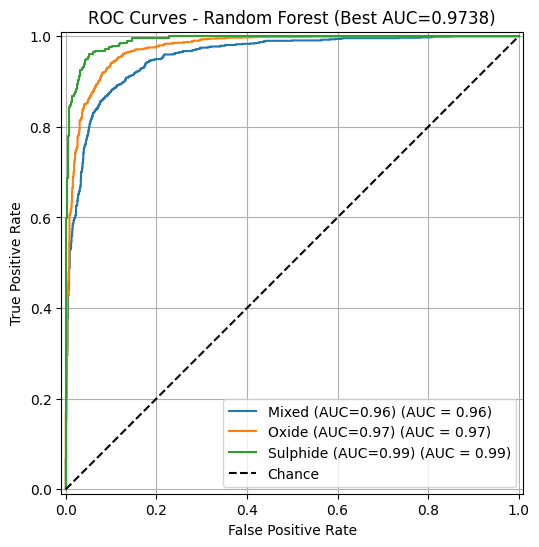

Model Random Search Progress:  25%|██▌       | 1/4 [04:42<14:08, 282.75s/it]


RANDOMIZED SEARCH & EVALUASI MODEL: Decision Tree

Best Parameters for Decision Tree:
{'classifier__min_samples_split': 10, 'classifier__max_depth': 5, 'classifier__criterion': 'log_loss'}
Best CV ROC AUC: 0.9310
Model saved successfully: models/best_model_decision_tree.pkl

Confusion Matrix:
          Mixed  Oxide  Sulphide
Mixed       984    158        50
Oxide       212   1322         0
Sulphide     88      3       191

Classification Report:
              precision    recall  f1-score   support

       Mixed       0.77      0.83      0.79      1192
       Oxide       0.89      0.86      0.88      1534
    Sulphide       0.79      0.68      0.73       282

    accuracy                           0.83      3008
   macro avg       0.82      0.79      0.80      3008
weighted avg       0.83      0.83      0.83      3008

Test ROC AUC (One-vs-Rest): 0.9308


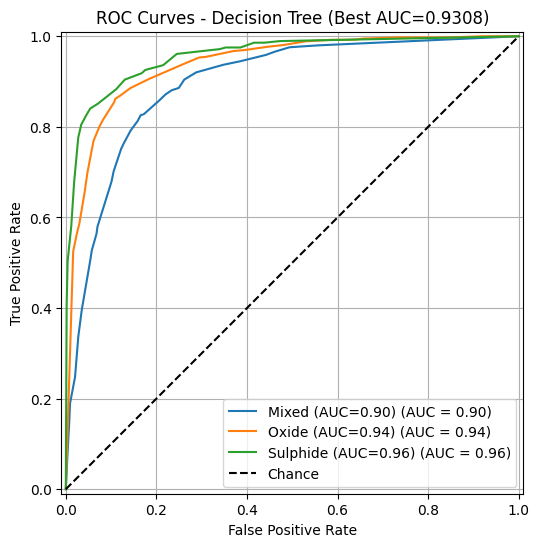

Model Random Search Progress:  50%|█████     | 2/4 [04:49<04:00, 120.42s/it]


RANDOMIZED SEARCH & EVALUASI MODEL: Logistic Regression

Best Parameters for Logistic Regression:
{'classifier__solver': 'liblinear', 'classifier__penalty': 'l2', 'classifier__C': np.float64(100.0)}
Best CV ROC AUC: 0.9231
Model saved successfully: models/best_model_logistic_regression.pkl

Confusion Matrix:
          Mixed  Oxide  Sulphide
Mixed       897    278        17
Oxide       140   1393         1
Sulphide    150      2       130

Classification Report:
              precision    recall  f1-score   support

       Mixed       0.76      0.75      0.75      1192
       Oxide       0.83      0.91      0.87      1534
    Sulphide       0.88      0.46      0.60       282

    accuracy                           0.80      3008
   macro avg       0.82      0.71      0.74      3008
weighted avg       0.81      0.80      0.80      3008

Test ROC AUC (One-vs-Rest): 0.9203


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


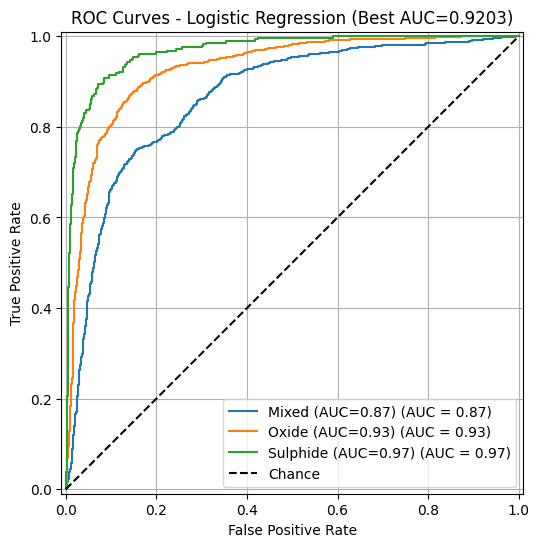

Model Random Search Progress:  75%|███████▌  | 3/4 [04:53<01:07, 67.11s/it] 


RANDOMIZED SEARCH & EVALUASI MODEL: KNN

Best Parameters for KNN:
{'classifier__weights': 'distance', 'classifier__p': 1, 'classifier__n_neighbors': 11}
Best CV ROC AUC: 0.9615
Model saved successfully: models/best_model_knn.pkl

Confusion Matrix:
          Mixed  Oxide  Sulphide
Mixed      1014    152        26
Oxide       104   1430         0
Sulphide     68      0       214

Classification Report:
              precision    recall  f1-score   support

       Mixed       0.85      0.85      0.85      1192
       Oxide       0.90      0.93      0.92      1534
    Sulphide       0.89      0.76      0.82       282

    accuracy                           0.88      3008
   macro avg       0.88      0.85      0.86      3008
weighted avg       0.88      0.88      0.88      3008

Test ROC AUC (One-vs-Rest): 0.9568


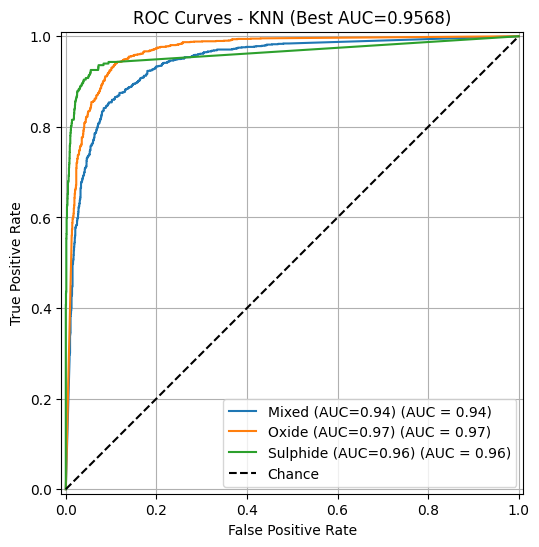

Model Random Search Progress: 100%|██████████| 4/4 [05:06<00:00, 76.70s/it]


In [14]:
from sklearn.model_selection import RandomizedSearchCV
import os

# =====================================
# Hyperparameter grids
# =====================================
param_dists = {
    'Random Forest': {
        'classifier__n_estimators': [100, 200, 300, 500],
        'classifier__max_depth': [5, 10, 15, 20, None],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4]
    },
    'Decision Tree': {
        'classifier__max_depth': [5, 10, 15, 20, None],
        'classifier__criterion': ['gini', 'entropy', 'log_loss'],
        'classifier__min_samples_split': [2, 5, 10]
    },
    'Logistic Regression': {
        'classifier__C': np.logspace(-2, 2, 10),
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear']
    },
    'KNN': {
        'classifier__n_neighbors': [3, 5, 7, 9, 11],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__p': [1, 2]
    }
}

# =====================================
# CV strategy & container
# =====================================
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results_summary = []

# =====================================
# RandomizedSearchCV Loop
# =====================================
for model_name, model in tqdm(models.items(), desc="Model Random Search Progress", position=0):
    print("\n" + "="*70)
    print(f"RANDOMIZED SEARCH & EVALUASI MODEL: {model_name}")
    print("="*70)

    # Pipeline: preprocessing + classifier
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Randomized Search setup
    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_dists[model_name],
        n_iter=15,                        # reduce for speed
        scoring='roc_auc_ovr',
        cv=cv_strategy,
        n_jobs=-1,
        random_state=42,
        verbose=0
    )

    # Fit on training data
    random_search.fit(X_train, y_train_encoded)

    print(f"\nBest Parameters for {model_name}:")
    print(random_search.best_params_)
    print(f"Best CV ROC AUC: {random_search.best_score_:.4f}")

    # --- Save best model to models/ directory ---
    best_model = random_search.best_estimator_

    # Pastikan folder 'models' ada
    os.makedirs('models', exist_ok=True)

    # Tentukan nama file model
    model_filename = f"best_model_{model_name.replace(' ', '_').lower()}.pkl"
    model_path = os.path.join('models', model_filename)

    # Simpan model ke file
    with open(model_path, 'wb') as f:
        pickle.dump(best_model, f)

    print(f"Model saved successfully: {model_path}")

    # Evaluate on test set
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(pd.DataFrame(cm, index=target_encoder.classes_, columns=target_encoder.classes_))

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=target_encoder.classes_))

    # ROC AUC
    lb = LabelBinarizer()
    y_test_binarized = lb.fit_transform(y_test)
    roc_auc = roc_auc_score(y_test_binarized, y_proba, multi_class='ovr')
    print(f"Test ROC AUC (One-vs-Rest): {roc_auc:.4f}")

    # Plot ROC Curves
    plt.figure(figsize=(8,6))
    for i, cls in enumerate(target_encoder.classes_):
        RocCurveDisplay.from_predictions(
            y_test_binarized[:, i],
            y_proba[:, i],
            name=f"{cls} (AUC={roc_auc_score(y_test_binarized[:, i], y_proba[:, i]):.2f})",
            ax=plt.gca()
        )
    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.title(f'ROC Curves - {model_name} (Best AUC={roc_auc:.4f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    # Append results
    results_summary.append({
        'Model': model_name,
        'Best_Params': random_search.best_params_,
        'CV_ROC_AUC': random_search.best_score_,
        'Test_ROC_AUC': roc_auc
    })

In [15]:
# =====================================
# Summary Comparison Table
# =====================================
summary_df = pd.DataFrame(results_summary)
summary_df = summary_df.sort_values(by='Test_ROC_AUC', ascending=False).round(4)

print("\n=== SUMMARY COMPARISON ===")
summary_df


=== SUMMARY COMPARISON ===


Model                                        Best_Params  \
0        Random Forest  {'classifier__n_estimators': 500, 'classifier_...   
3                  KNN  {'classifier__weights': 'distance', 'classifie...   
1        Decision Tree  {'classifier__min_samples_split': 10, 'classif...   
2  Logistic Regression  {'classifier__solver': 'liblinear', 'classifie...   

   CV_ROC_AUC  Test_ROC_AUC  
0      0.9733        0.9738  
3      0.9615        0.9568  
1      0.9310        0.9308  
2      0.9231        0.9203

In [29]:
import os
import pickle
import pandas as pd
import numpy as np
from ipywidgets import (
    VBox, HBox, Dropdown, Button, FileUpload, RadioButtons, FloatText, Output, Label
)
from IPython.display import display

# =========================================
# Load saved models
# =========================================
MODEL_DIR = "models"
models = {}

for fname in os.listdir(MODEL_DIR):
    if fname.endswith(".pkl"):
        with open(os.path.join(MODEL_DIR, fname), "rb") as f:
            model = pickle.load(f)
            model_name = fname.replace("best_model_", "").replace(".pkl", "").replace("_", " ").title()
            models[model_name] = model

# =========================================
# Widgets
# =========================================
model_dropdown = Dropdown(
    options=list(models.keys()),
    description="Model:",
    style={'description_width': '80px'}
)

input_mode = RadioButtons(
    options=["Upload CSV", "Manual Input"],
    description="Input mode:",
    style={'description_width': '80px'}
)

file_upload = FileUpload(accept=".csv", multiple=False)

predict_button = Button(
    description="Predict",
    button_style='success',
    tooltip="Run prediction",
    icon="check"
)

output = Output()

# =========================================
# Manual input widgets (built dynamically)
# =========================================
def build_manual_inputs(model):
    feature_names = model.named_steps['preprocessor'].get_feature_names_out()
    inputs = {f: FloatText(description=f, value=0.0, style={'description_width': '150px'}) for f in feature_names}
    return inputs

manual_inputs = build_manual_inputs(models[list(models.keys())[0]])

# =========================================
# Callback function
# =========================================
def on_predict_clicked(b):
    output.clear_output()
    model_name = model_dropdown.value
    model = models[model_name]

    try:
        if input_mode.value == "Upload CSV" and len(file_upload.value) > 0:
            uploaded = list(file_upload.value.values())[0]
            input_df = pd.read_csv(pd.io.common.BytesIO(uploaded['content']))
        else:
            input_dict = {f: w.value for f, w in manual_inputs.items()}
            input_df = pd.DataFrame([input_dict])

        y_pred = model.predict(input_df)
        y_proba = model.predict_proba(input_df)

        with output:
            display(Label(f"Model: {model_name}"))
            display(Label(f"Predicted Ore Type: {y_pred[0]}"))
            display(pd.DataFrame(y_proba, columns=model.classes_))
    except Exception as e:
        with output:
            display(Label(f"Error during prediction: {e}"))

predict_button.on_click(on_predict_clicked)

# =========================================
# Layout
# =========================================
def update_input_mode(change):
    with output:
        output.clear_output()
    if input_mode.value == "Manual Input":
        display(VBox(list(manual_inputs.values())))
    else:
        display(file_upload)

input_mode.observe(update_input_mode, names='value')

# =========================================
# Display UI
# =========================================
display(VBox([
    Label("Ore Type Prediction Interface (Jupyter + ipywidgets)"),
    model_dropdown,
    input_mode,
    file_upload,
    VBox(list(manual_inputs.values())),
    predict_button,
    output
]))


## Cost Evaluation

Saran tindakan selanjutnya (konkrit)
- Tentukan apa yang lebih mahal: salah prediksi sulphide→oxide atau oxide→sulphide? Kuantifikasi (Rp/ton) jika mungkin.
- Isi cost_matrix dengan nilai ekonomi nyata; gunakan metric custom itu untuk memilih model.
- Kalau kelas minor (mis. sulphide) penting → optimalkan recall untuk kelas tersebut, tapi pantau precision agar false alarms tak menenggelamkan operasi.
- Simpan semua metrik tiap eksperimen (MLflow/W&B) agar bisa trade-off explicit antar model.

Asumsi domain (ringkas)
- Sulphide = umumnya higher-value → kehilangan klasifikasi ini mahal (lost revenue & recovery drop).
- Oxide = umumnya lower-value, tapi jika diproses seperti sulphide akan menambah biaya energi + reagent (over-processing).
- Mixed = di tengah; baik under- maupun over-treatment punya biaya sedang.
- Contoh angka asumsi: harga/penalty per ton dan biaya pengolahan digambarkan bulat untuk kemudahan (Rp).

Contoh kuantifikasi (Rp/ton) — interpretasi cepat
- Under-treating sulphide → oxide: sangat mahal (lost revenue + recovery) → Rp 450.000 / ton
- Under-treating sulphide → mixed: kurang parah tapi masih mahal → Rp 200.000 / ton
- Over-treating oxide → sulphide: biaya energi + reagent + handling → Rp 180.000 / ton
- Over-treating oxide → mixed: biaya sedang → Rp 120.000 / ton
- Mixed misclassifications: moderate (over or under) → Rp 60.000–80.000 / ton

In [16]:
classes = ["mixed", "sulphide", "oxide"]
label_to_idx = {lab: i for i, lab in enumerate(classes)}

# Cost matrix in Rp/ton (row=true, col=pred)
cost_matrix = np.array([
    [0,       80_000,  60_000],   # true = mixed
    [200_000,     0,   450_000],  # true = sulphide
    [120_000, 180_000,      0]    # true = oxide
])

def compute_avg_cost(y_true, y_pred, cost_matrix, label_to_idx):
    idx_true = np.array([label_to_idx[t] for t in y_true])
    idx_pred = np.array([label_to_idx[p] for p in y_pred])
    costs = cost_matrix[idx_true, idx_pred]
    return costs.mean(), costs.sum()  # rata-rata Rp/ton, total Rp

# Contoh pemakaian
y_true = ["sulphide","oxide","mixed","sulphide","oxide"]
y_pred = ["oxide","oxide","sulphide","mixed","mixed"]

avg_cost, total_cost = compute_avg_cost(y_true, y_pred, cost_matrix, label_to_idx)
print(f"Avg penalty (Rp/ton): {avg_cost:,.0f}")
print(f"Total penalty (Rp): {total_cost:,.0f}")


Avg penalty (Rp/ton): 170,000
Total penalty (Rp): 850,000


Rekomendasi & trade-offs (kritis)

- Jangan pakai angka ini apa adanya untuk keputusan produksi. Angka harus dikalibrasi ke: harga concentrate, recovery impact per ton, biaya energi & reagent, dan kontrak off-taker.
- Lakukan sensitivity analysis: jalankan eksperimen dengan skenario low/medium/high penalty (mis. ±30%) untuk lihat stabilitas pemilihan model.
- Jika misclassification sulphide sangat mahal → prioritaskan recall untuk sulphide (bisa set class_weight atau thresholding probabilitas). Tapi hati-hati: meningkatkan recall bisa meningkatkan false positives → biaya over-processing. It’s a trade-off ekonomi.
- Simpan asumsi dan metadata (unit Rp/ton, periode, sumber angka) bersama model (mis. di MLflow) supaya keputusan dapat diaudit.
- Pertimbangkan menghitung biaya per-batch (ton × Rp/ton) karena operasi biasanya berjalan batch/shift.

In [18]:
# Hitung persentase kelas ore_type_label per hari (3 kolom: mixed, oxide, sulphide)
# Menggunakan dataset yang sudah ada dan kolom 'date' (datetime)

# Pastikan kolom tanggal hanya tanggal (tanpa jam)
dataset['date'] = pd.to_datetime(dataset['date']).dt.date

# Hitung jumlah per hari per kelas, lalu ubah ke persentase
counts_per_day = dataset.groupby(['date', 'ore_type_label']).size().unstack(fill_value=0)

# Pastikan urutan kolom dan isi semua kelas (jika suatu hari tidak ada kelas, beri 0)
for cls in ['Mixed', 'Oxide', 'Sulphide']:
    if cls not in counts_per_day.columns:
        counts_per_day[cls] = 0
counts_per_day = counts_per_day[['Mixed', 'Oxide', 'Sulphide']]

pct_per_day = counts_per_day.div(counts_per_day.sum(axis=1), axis=0) * 100

# Ubah nama kolom ke lowercase sesuai permintaan (mixed, oxide, sulphide)
pct_per_day = pct_per_day.rename(columns=lambda c: c.lower()).reset_index()

# Tampilkan hasil (head)
pct_per_day.head()

print(pct_per_day.shape)

(730, 4)


In [19]:
pct_per_day.tail()

ore_type_label        date      mixed      oxide  sulphide
725             2024-12-26  33.333333  57.142857   9.52381
726             2024-12-27  38.095238  61.904762   0.00000
727             2024-12-28  10.000000  80.000000  10.00000
728             2024-12-29  38.095238  61.904762   0.00000
729             2024-12-30  42.857143  57.142857   0.00000

In [20]:
pct_per_day['date'] = pd.to_datetime(pct_per_day['date'])

# Data Generating Process Tonnage

In [21]:
# 1. Date range harian 2 tahun
dates = pd.date_range(start="2023-01-01", end="2025-01-21", freq='D')
n = len(dates)

# 2. Random seed
np.random.seed(42)

# 3. Trend (misal +0.5 t per hari)
trend = np.linspace(10000, 12000, n)  # mulai 10k t/day → 12k t/day setelah 2 tahun

# 4. Musiman mingguan (shift / hari kerja vs weekend)
weekly_seasonality = 500 * np.sin(2 * np.pi * np.arange(n) / 7)  # ±500 t fluktuasi mingguan

# 5. Musiman tahunan (maintenance, curah hujan, dll)
annual_seasonality = 800 * np.sin(2 * np.pi * np.arange(n) / 365.25)  # ±800 t per tahun

# 6. Noise besar (realistis)
noise = np.random.normal(0, 1000, n)  # std dev 1000 t

# 7. Holiday effect (misal shutdown tertentu)
holidays = ['2023-01-01','2023-12-25','2024-01-01','2024-12-25']  # contoh
holiday_effect = np.array([ -2000 if d.strftime('%Y-%m-%d') in holidays else 0 for d in dates])

# 8. Dummy tonnage = trend + seasonality + noise + holiday
tonnage = trend + weekly_seasonality + annual_seasonality + noise + holiday_effect
tonnage = np.round(tonnage).astype(int)  # integer tonnage

# 11. Build DataFrame
df = pd.DataFrame({
        'date': dates,
        'tonnage': tonnage,
})

# 12. Tampilkan contoh
df.to_csv('simulated_tonnage.csv', index=False)

In [24]:
df_tonnage = pd.read_csv('./simulated_tonnage.csv', parse_dates=['date'])
df_tonnage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 752 entries, 0 to 751
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     752 non-null    datetime64[ns]
 1   tonnage  752 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 11.9 KB


In [25]:
df_tonnage['date'] = pd.to_datetime(df_tonnage['date']).dt.date

In [26]:
df_tonnage['date'] = pd.to_datetime(df_tonnage['date']).dt.date
pct_per_day['date'] = pd.to_datetime(pct_per_day['date']).dt.date

In [27]:
df_pct_tonnage = pd.merge(pct_per_day, df_tonnage, on='date', how='left')

In [28]:
prophet_df = df_pct_tonnage.rename(columns={
    'date': 'ds',
    'tonnage': 'y'
})

# Train/test split for Prophet and compute RMSE & MAPE
test_periods = 90  # adjust as needed

# Ensure sorted
prophet_df = prophet_df.sort_values('ds').reset_index(drop=True)

if test_periods >= len(prophet_df):
    raise ValueError("test_periods is >= number of observations. Reduce test_periods.")

# Split
train_df = prophet_df.iloc[:-test_periods].copy()
test_df = prophet_df.iloc[-test_periods:].copy()

# Regressors present in prophet_df (exclude 'ds' and 'y')
regressors = [c for c in prophet_df.columns if c not in ['ds','y']]

# Build and fit Prophet with regressors (if any)
from prophet import Prophet

m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False, seasonality_mode='additive')
for r in regressors:
    m.add_regressor(r)

m.fit(train_df[['ds','y'] + regressors])

# Predict on test set (must supply regressors for test ds)
pred = m.predict(test_df[['ds'] + regressors])

# Align actuals and predictions
y_true = test_df['y'].values
y_pred = pred['yhat'].values

# Metrics: RMSE and MAPE (handle zeros in y_true)
import numpy as np
rmse = np.sqrt(np.mean((y_true - y_pred)**2))
nonzero_mask = y_true != 0
if nonzero_mask.sum() == 0:
    mape = np.nan
else:
    mape = np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100

print(f"Test periods: {len(y_true)}")
print(f"RMSE: {rmse:,.2f}")
print(f"MAPE: {mape:.2f}%")

# Plot actual vs predicted for test period
plt.figure(figsize=(12,5))
plt.plot(train_df['ds'], train_df['y'], label='Train (actual)', color='gray', alpha=0.6)
plt.plot(test_df['ds'], y_true, label='Test (actual)', marker='o')
plt.plot(test_df['ds'], y_pred, label='Test (predicted)', marker='x')
plt.xlabel('ds')
plt.ylabel('tonnage')
plt.title('Prophet: Actual vs Predicted (Test Set)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Inspect residuals
residuals = y_true - y_pred
plt.figure(figsize=(10,3))
plt.plot(test_df['ds'], residuals, marker='o')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('ds')
plt.ylabel('Residual (actual - pred)')
plt.title('Forecast Residuals (Test Set)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

AttributeError: 'Prophet' object has no attribute 'stan_backend'

09:37:34 - cmdstanpy - INFO - Chain [1] start processing
09:37:34 - cmdstanpy - INFO - Chain [1] done processing
09:38:01 - cmdstanpy - INFO - Chain [1] start processing
09:38:02 - cmdstanpy - INFO - Chain [1] done processing
09:38:22 - cmdstanpy - INFO - Chain [1] start processing
09:38:22 - cmdstanpy - INFO - Chain [1] done processing
09:38:44 - cmdstanpy - INFO - Chain [1] start processing
09:38:44 - cmdstanpy - INFO - Chain [1] done processing
09:39:11 - cmdstanpy - INFO - Chain [1] start processing
09:39:12 - cmdstanpy - INFO - Chain [1] done processing
09:39:42 - cmdstanpy - INFO - Chain [1] start processing
09:39:42 - cmdstanpy - INFO - Chain [1] done processing
09:40:11 - cmdstanpy - INFO - Chain [1] start processing
09:40:12 - cmdstanpy - INFO - Chain [1] done processing
09:40:43 - cmdstanpy - INFO - Chain [1] start processing
09:40:44 - cmdstanpy - INFO - Chain [1] done processing
09:41:12 - cmdstanpy - INFO - Chain [1] start processing
09:41:12 - cmdstanpy - INFO - Chain [1]


Best Hyperparameters (based on lowest RMSE):

cps                      0.100000
sps                      1.000000
n_changepoints          10.000000
fourier_order_yearly     5.000000
fourier_order_weekly     3.000000
rmse                    10.938443
mape                     0.343315
Name: 32, dtype: float64


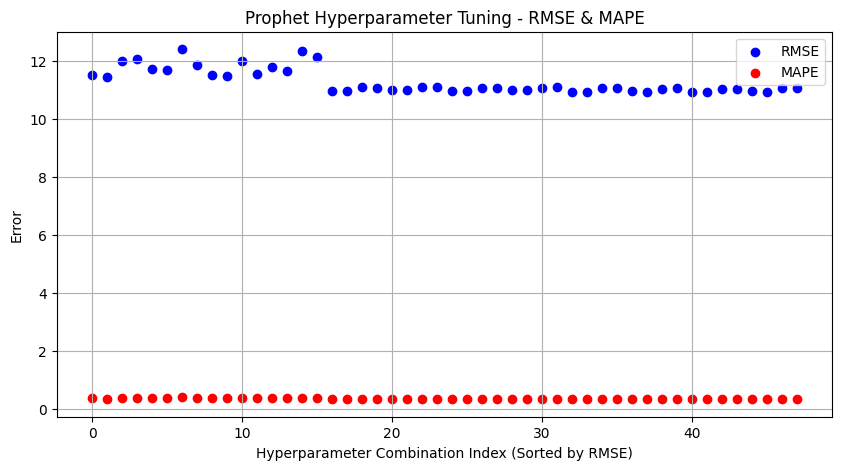

In [ ]:
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from itertools import product
import matplotlib.pyplot as plt

# --- Hyperparameter grid ---
param_grid = {
    'changepoint_prior_scale': [0.01, 0.05, 0.1],
    'seasonality_prior_scale': [1.0, 2.0],
    'n_changepoints': [10, 25],
    'fourier_order_yearly': [5, 8],
    'fourier_order_weekly': [3, 5]
}

results = []

# Iterate over all combinations
for cps, sps, ncp, foy, fow in product(
    param_grid['changepoint_prior_scale'],
    param_grid['seasonality_prior_scale'],
    param_grid['n_changepoints'],
    param_grid['fourier_order_yearly'],
    param_grid['fourier_order_weekly']):

    # Initialize Prophet with current combination
    m = Prophet(
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode='multiplicative',
        changepoint_prior_scale=cps,
        seasonality_prior_scale=sps,
        n_changepoints=ncp
    )

    # Add custom seasonalities
    m.add_seasonality(name='yearly', period=365.25, fourier_order=foy)
    m.add_seasonality(name='weekly', period=7, fourier_order=fow)

    # Add lagged regressors
    m.add_regressor('oxide_lag1')
    m.add_regressor('sulphide_lag1')

    # Fit model
    m.fit(train_df[['ds', 'y', 'oxide_lag1', 'sulphide_lag1']])

    # Cross-validation horizon = 30 days
    # NOTE: 'initial' dan 'period' di cross_validation akan menggunakan nilai default jika tidak didefinisikan.
    try:
        df_cv = cross_validation(m, horizon='30 days', parallel="processes")
        df_p = performance_metrics(df_cv, metrics=['rmse', 'mape'])

        results.append({
            'cps': cps,
            'sps': sps,
            'n_changepoints': ncp,
            'fourier_order_yearly': foy,
            'fourier_order_weekly': fow,
            'rmse': df_p['rmse'].mean(),
            'mape': df_p['mape'].mean()
        })
    except Exception as e:
        # Handle cases where CV might fail (misalnya, jika data training terlalu sedikit)
        print(f"CV failed for combination {cps}, {sps}, {ncp}, {foy}, {fow}. Error: {e}")
        continue


# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Sort by RMSE (as the primary metric for optimization)
results_df = results_df.sort_values('rmse')

# Select the best performing set of hyperparameters
best_params = results_df.iloc[0]

print("\nBest Hyperparameters (based on lowest RMSE):\n")
print(best_params)

# --- Visualisasi RMSE dan MAPE per kombinasi ---
plt.figure(figsize=(10, 5))

# Gunakan indeks DataFrame sebagai sumbu X
plt.scatter(results_df.index, results_df['rmse'], label='RMSE', color='blue')
plt.scatter(results_df.index, results_df['mape'], label='MAPE', color='red')

plt.xlabel("Hyperparameter Combination Index (Sorted by RMSE)")
plt.ylabel("Error")
plt.title("Prophet Hyperparameter Tuning - RMSE & MAPE")
plt.legend()
plt.grid(True)
plt.show()

09:28:48 - cmdstanpy - INFO - Chain [1] start processing
09:28:48 - cmdstanpy - INFO - Chain [1] done processing


Test periods: 90
RMSE: 10.36
MAPE: 25.33%


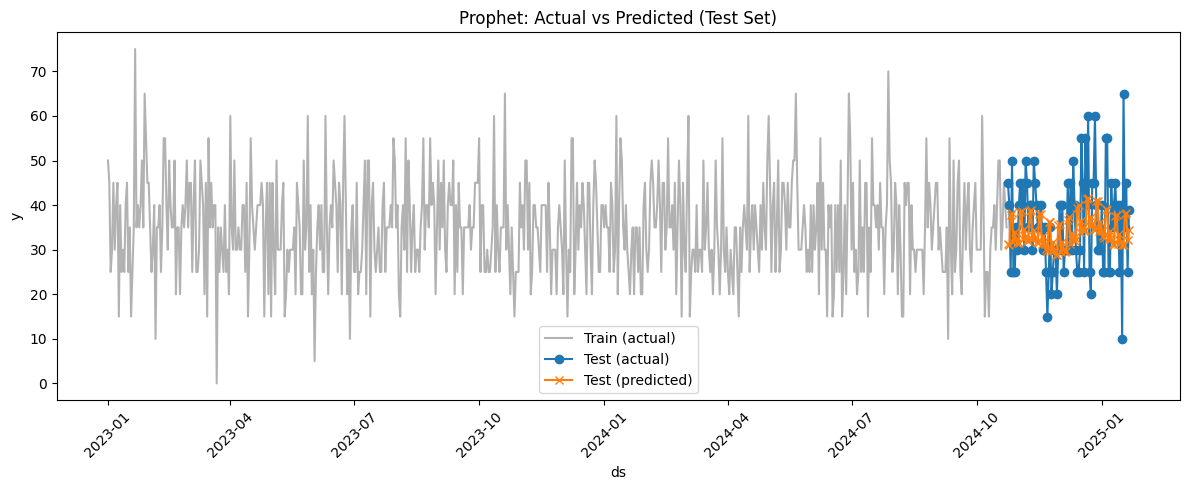

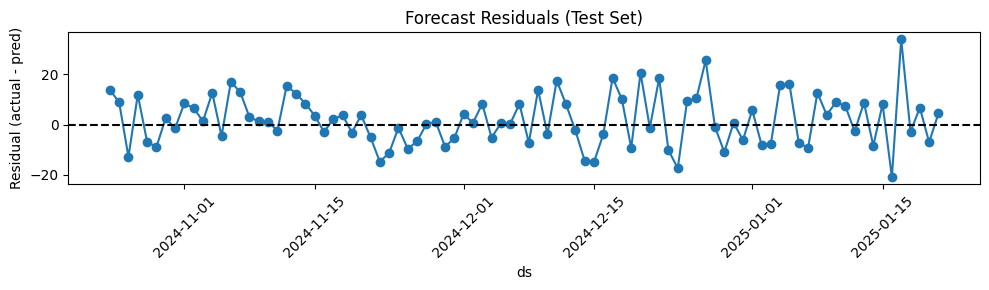

In [ ]:
# Prepare univariate dataframe
prophet_pct_oxide_df = df_pct_tonnage.rename(columns={'date': 'ds', 'oxide': 'y'})

# Ensure sorted
prophet_pct_oxide_df = prophet_pct_oxide_df.sort_values('ds').reset_index(drop=True)

# Train/test split
test_periods = 90

if test_periods >= len(prophet_pct_oxide_df):
    raise ValueError("test_periods is >= number of observations. Reduce test_periods.")

train_df = prophet_pct_oxide_df.iloc[:-test_periods].copy()
test_df = prophet_pct_oxide_df.iloc[-test_periods:].copy()

# Initialize Prophet without regressors
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='additive'
)

# Fit on training data
m.fit(train_df[['ds', 'y']])

# Forecast
pred = m.predict(test_df[['ds']])

# Align actuals and predictions
y_true = test_df['y'].values
y_pred = pred['yhat'].values

# Metrics: RMSE and MAPE
rmse = np.sqrt(np.mean((y_true - y_pred)**2))
nonzero_mask = y_true != 0
mape = np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100

print(f"Test periods: {len(y_true)}")
print(f"RMSE: {rmse:,.2f}")
print(f"MAPE: {mape:.2f}%")

# Plot actual vs predicted
plt.figure(figsize=(12, 5))
plt.plot(train_df['ds'], train_df['y'], label='Train (actual)', color='gray', alpha=0.6)
plt.plot(test_df['ds'], y_true, label='Test (actual)', marker='o')
plt.plot(test_df['ds'], y_pred, label='Test (predicted)', marker='x')
plt.xlabel('ds')
plt.ylabel('y')
plt.title('Prophet: Actual vs Predicted (Test Set)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Residual plot
residuals = y_true - y_pred

plt.figure(figsize=(10, 3))
plt.plot(test_df['ds'], residuals, marker='o')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('ds')
plt.ylabel('Residual (actual - pred)')
plt.title('Forecast Residuals (Test Set)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

09:28:56 - cmdstanpy - INFO - Chain [1] start processing
09:28:56 - cmdstanpy - INFO - Chain [1] done processing


Test periods: 90
RMSE: 11.91
MAPE: 40.06%


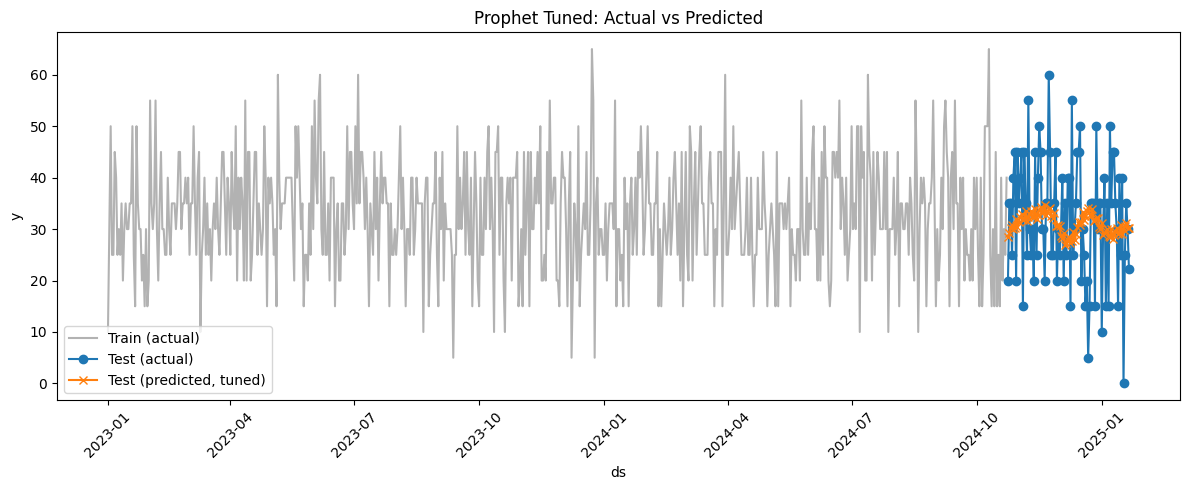

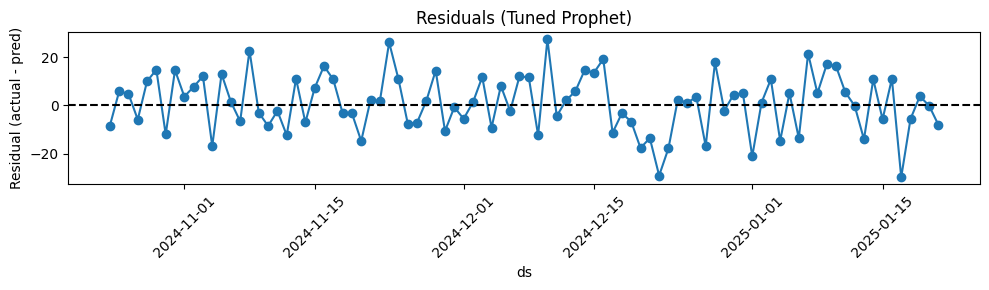

In [ ]:
from prophet.diagnostics import cross_validation, performance_metrics
from prophet import Prophet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Prepare Data ---
prophet_pct_mixed_df = df_pct_tonnage.rename(columns={'date': 'ds', 'mixed': 'y'})
prophet_pct_mixed_df = prophet_pct_mixed_df.sort_values('ds').reset_index(drop=True)

test_periods = 90
train_df = prophet_pct_mixed_df.iloc[:-test_periods].copy()
test_df = prophet_pct_mixed_df.iloc[-test_periods:].copy()

# --- Tuned Prophet Model ---
m = Prophet(
    yearly_seasonality=False,  # We'll add it manually
    weekly_seasonality=False,  # Manual tuning gives more control
    daily_seasonality=False,
    seasonality_mode='multiplicative',  # Often better for percentage-like targets
    changepoint_prior_scale=0.2,  # ↑ allows more flexible trend
    seasonality_prior_scale=10.0,  # ↑ allows stronger seasonal swings
    n_changepoints=50              # ↑ allows more inflection points in trend
)

# Add seasonality components manually
m.add_seasonality(name='yearly', period=365.25, fourier_order=15)
m.add_seasonality(name='weekly', period=7, fourier_order=5)

# Fit the model
m.fit(train_df[['ds', 'y']])

# Forecast
pred = m.predict(test_df[['ds']])

# --- Metrics ---
y_true = test_df['y'].values
y_pred = pred['yhat'].values

rmse = np.sqrt(np.mean((y_true - y_pred)**2))
nonzero_mask = y_true != 0
mape = np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100

print(f"Test periods: {len(y_true)}")
print(f"RMSE: {rmse:,.2f}")
print(f"MAPE: {mape:.2f}%")

# --- Plot ---
plt.figure(figsize=(12, 5))
plt.plot(train_df['ds'], train_df['y'], label='Train (actual)', color='gray', alpha=0.6)
plt.plot(test_df['ds'], y_true, label='Test (actual)', marker='o')
plt.plot(test_df['ds'], y_pred, label='Test (predicted, tuned)', marker='x')
plt.xlabel('ds')
plt.ylabel('y')
plt.title('Prophet Tuned: Actual vs Predicted')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Residuals ---
residuals = y_true - y_pred
plt.figure(figsize=(10, 3))
plt.plot(test_df['ds'], residuals, marker='o')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('ds')
plt.ylabel('Residual (actual - pred)')
plt.title('Residuals (Tuned Prophet)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
from prophet.diagnostics import cross_validation, performance_metrics

df_cv = cross_validation(m, initial='365 days', period='90 days', horizon='90 days')
df_p = performance_metrics(df_cv)
df_p[['horizon', 'rmse', 'mape']].head()

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/3 [00:00<?, ?it/s]09:29:22 - cmdstanpy - INFO - Chain [1] start processing
09:29:22 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:01<00:02,  1.05s/it]09:29:22 - cmdstanpy - INFO - Chain [1] start processing
09:29:22 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:01<00:00,  1.44it/s]09:29:23 - cmdstanpy - INFO - Chain [1] start processing
09:29:23 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:02<00:00,  1.30it/s]


horizon      rmse      mape
0  9 days  9.229872  0.350864
1 10 days  9.237959  0.288067
2 11 days  9.524677  0.291253
3 12 days  9.476827  0.283352
4 13 days  9.958998  0.298878

09:29:09 - cmdstanpy - INFO - Chain [1] start processing
09:29:09 - cmdstanpy - INFO - Chain [1] done processing


Test periods: 90
RMSE: 11.84
MAPE: 43.80%


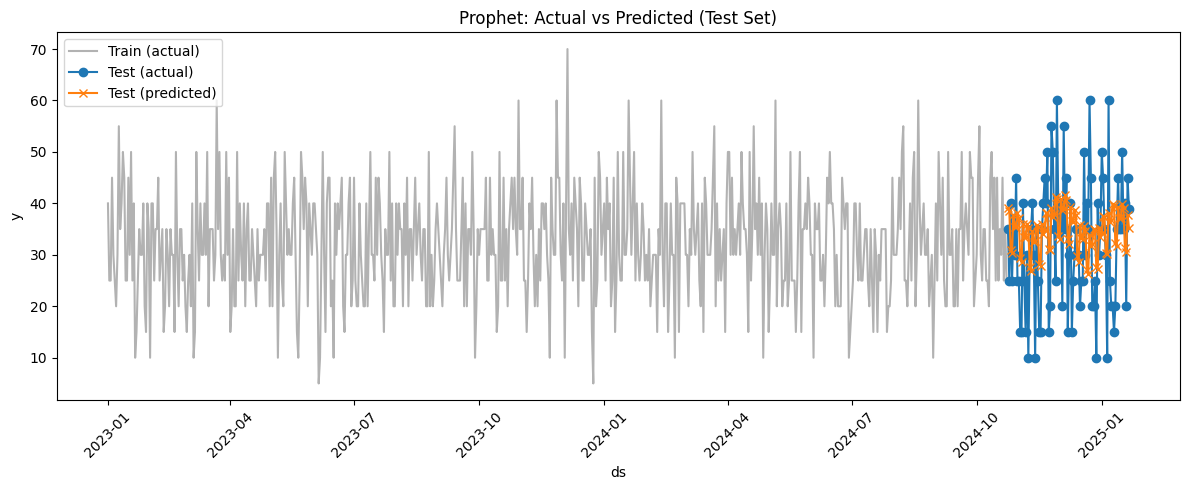

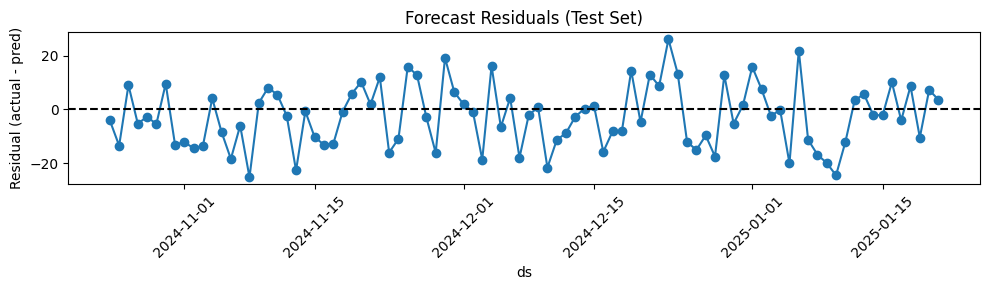

In [ ]:
# Prepare univariate dataframe
prophet_pct_sulphide_df = df_pct_tonnage.rename(columns={'date': 'ds', 'sulphide': 'y'})

# Ensure sorted
prophet_pct_sulphide_df = prophet_pct_sulphide_df.sort_values('ds').reset_index(drop=True)

# Train/test split
test_periods = 90

if test_periods >= len(prophet_pct_sulphide_df):
    raise ValueError("test_periods is >= number of observations. Reduce test_periods.")

train_df = prophet_pct_sulphide_df.iloc[:-test_periods].copy()
test_df = prophet_pct_sulphide_df.iloc[-test_periods:].copy()

# Initialize Prophet without regressors
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='additive'
)

# Fit on training data
m.fit(train_df[['ds', 'y']])

# Forecast
pred = m.predict(test_df[['ds']])

# Align actuals and predictions
y_true = test_df['y'].values
y_pred = pred['yhat'].values

# Metrics: RMSE and MAPE
rmse = np.sqrt(np.mean((y_true - y_pred)**2))
nonzero_mask = y_true != 0
mape = np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100

print(f"Test periods: {len(y_true)}")
print(f"RMSE: {rmse:,.2f}")
print(f"MAPE: {mape:.2f}%")

# Plot actual vs predicted
plt.figure(figsize=(12, 5))
plt.plot(train_df['ds'], train_df['y'], label='Train (actual)', color='gray', alpha=0.6)
plt.plot(test_df['ds'], y_true, label='Test (actual)', marker='o')
plt.plot(test_df['ds'], y_pred, label='Test (predicted)', marker='x')
plt.xlabel('ds')
plt.ylabel('y')
plt.title('Prophet: Actual vs Predicted (Test Set)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Residual plot
residuals = y_true - y_pred

plt.figure(figsize=(10, 3))
plt.plot(test_df['ds'], residuals, marker='o')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('ds')
plt.ylabel('Residual (actual - pred)')
plt.title('Forecast Residuals (Test Set)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Hitung tonnage per ore type
df_pct_tonnage['sulphide_ton'] = df_pct_tonnage['sulphide'] * df_pct_tonnage['tonnage']/100
df_pct_tonnage['oxide_ton'] = df_pct_tonnage['oxide'] * df_pct_tonnage['tonnage']/100
df_pct_tonnage['mixed_ton'] = df_pct_tonnage['mixed'] * df_pct_tonnage['tonnage']/100

# Hitung biaya/revenue impact
df_pct_tonnage['Cost_impact_Rp'] = (
    df_pct_tonnage['sulphide_ton'] * 500 +
    df_pct_tonnage['oxide_ton'] * 0 +
    df_pct_tonnage['mixed_ton'] * 250
)

# Hitung energy usage
df_pct_tonnage['Energy_kWh'] = (
    df_pct_tonnage['sulphide_ton'] * 1.2 +
    df_pct_tonnage['oxide_ton'] * 1.0 +
    df_pct_tonnage['mixed_ton'] * 1.1
)

# Hitung deviasi jika proporsi berbeda dari target
target_sulphide = 0.45
df_pct_tonnage['sulphide_dev_ton'] = (df_pct_tonnage['sulphide'] - target_sulphide) * df_pct_tonnage['tonnage']
df_pct_tonnage['Deviation_cost_Rp'] = df_pct_tonnage['sulphide_dev_ton'] * 500

df_pct_tonnage[['date','sulphide','oxide','mixed','sulphide_ton','Cost_impact_Rp','Energy_kWh','Deviation_cost_Rp']]


date   sulphide      oxide      mixed  sulphide_ton   
0    2023-01-01  15.000000  45.000000  40.000000       1274.55  \
1    2023-01-02  40.000000  40.000000  20.000000       4107.60   
2    2023-01-03  20.000000  50.000000  30.000000       2233.60   
3    2023-01-04  30.000000  50.000000  20.000000       3536.70   
4    2023-01-05  25.000000  50.000000  25.000000       2403.75   
..          ...        ...        ...        ...           ...   
747  2025-01-17   5.000000  75.000000  20.000000        548.55   
748  2025-01-18  15.000000  55.000000  30.000000       1684.05   
749  2025-01-19  15.000000  70.000000  15.000000       1625.70   
750  2025-01-20  25.000000  40.000000  35.000000       2932.00   
751  2025-01-21   5.555556  66.666667  27.777778        634.00   

     Cost_impact_Rp  Energy_kWh  Deviation_cost_Rp  
0         1486975.0    9091.790         61815675.0  
1         2567250.0   11295.900        203069475.0  
2         1954400.0   11949.760        109167200.0  
3         2357800.0   12732.120        174182475.0  
4         1802812.5   10336.125        118024125.0  
..              ...         ...                ...  
747        822825.0   11300.130         24959025.0  
748       1684050.0   11900.620         81676425.0  
749       1219275.0   11325.710         78846450.0  
750       2492200.0   12724.880        143961200.0  
751       1109500.0   11855.800         29132300.0  

[752 rows x 8 columns]

In [ ]:
# -----------------------------
# 2️⃣ Dummy Dataset 2 (Shift-Level Aggregation)
# -----------------------------
n_shifts = 200
shift_start_dates = pd.date_range(start='2025-11-01', periods=n_shifts, freq='8H')

dataset2 = pd.DataFrame({
    'shift_id': np.tile([1,2,3], n_shifts//3 + 1)[:n_shifts],
    'shift_start': shift_start_dates,
    'prob_sulphide': np.random.uniform(0.4, 0.9, n_shifts),
    'prob_oxide': np.random.uniform(0.1, 0.5, n_shifts),
    'prob_mixed': np.random.uniform(0.0, 0.2, n_shifts),
    'avg_mill_load': np.random.uniform(60, 90, n_shifts),
    'avg_solids_pct': np.random.uniform(35, 50, n_shifts),
    'avg_cyclone_pressure': np.random.uniform(100, 200, n_shifts),
    'feed_tonnage': np.random.uniform(1000, 1500, n_shifts),
    'pct_tonnage_from_PitA': np.random.uniform(0.3, 0.7, n_shifts),
    'rain_mm_last_24h': np.random.uniform(0, 10, n_shifts)
})

# -----------------------------
# 3️⃣ Dummy Dataset 3 (Prophet-ready)
# -----------------------------
dataset3 = dataset2.copy()
dataset3.rename(columns={'shift_start':'ds'}, inplace=True)

# Simulasi mill throughput (y) sebagai fungsi linear + noise dari regressor
dataset3['y'] = (dataset3['prob_sulphide']*0.5 +
                 dataset3['prob_oxide']*0.3 +
                 dataset3['avg_mill_load']*0.05 +
                 dataset3['feed_tonnage']*0.001 +
                 np.random.normal(0, 0.05, n_shifts)) * 1000  # scale ke ton/shift

# Dataset siap Prophet
prophet_dataset = dataset3[['ds','y','prob_sulphide','prob_oxide','prob_mixed',
                            'avg_mill_load','avg_solids_pct','avg_cyclone_pressure',
                            'feed_tonnage','pct_tonnage_from_PitA','rain_mm_last_24h']]

# Tampilkan head
print(prophet_dataset.head())

                   ds            y  prob_sulphide  prob_oxide  prob_mixed   
0 2025-11-01 00:00:00  5201.219804       0.738926    0.183930    0.149708  \
1 2025-11-01 08:00:00  6114.355508       0.484496    0.242781    0.012701   
2 2025-11-01 16:00:00  5087.012259       0.752401    0.413025    0.037146   
3 2025-11-02 00:00:00  4951.722307       0.770717    0.357505    0.083392   
4 2025-11-02 08:00:00  5570.574473       0.843440    0.230510    0.092530   

   avg_mill_load  avg_solids_pct  avg_cyclone_pressure  feed_tonnage   
0      64.802285       37.534709            105.809665   1483.240830  \
1      87.220093       46.832326            105.984719   1444.320516   
2      65.413702       42.563298            137.060140   1397.267101   
3      61.213023       42.690719            119.496396   1347.378758   
4      77.628770       40.431683            193.478079   1287.077773   

   pct_tonnage_from_PitA  rain_mm_last_24h  
0               0.588230          2.147900  
1             

In [ ]:
dataset1.head()

sample_id   pit  depth_mean     fe_pct    cu_pct  sio2_pct  moisture_pct   
0     S0000  PitC    4.579104  39.693019  0.830528  1.668883      1.739211  \
1     S0001  PitA   45.865679  43.091161  0.701281  2.896567      2.001111   
2     S0002  PitC    6.840932  54.623086  0.773487  4.445003      2.734731   
3     S0003  PitC   47.511868  59.229574  0.935929  2.846525      1.036861   
4     S0004  PitA   22.300289        NaN  0.493641  3.158612      1.864522   

     au_gpt ore_type_label  
0  1.955987       Sulphide  
1  1.988576          Oxide  
2  1.111234       Sulphide  
3  0.340285          Oxide  
4  0.632210       Sulphide

In [ ]:
dataset1.isna().sum()

sample_id          0
pit                0
depth_mean        76
fe_pct            76
cu_pct            80
sio2_pct          78
moisture_pct      78
au_gpt            77
ore_type_label     0
dtype: int64

In [ ]:
dataset2.head()

shift_id         shift_start  prob_sulphide  prob_oxide  prob_mixed   
0         1 2025-11-01 00:00:00       0.590572    0.287241    0.097938  \
1         2 2025-11-01 08:00:00       0.866406    0.396207    0.022087   
2         3 2025-11-01 16:00:00       0.757582    0.433002    0.094317   
3         1 2025-11-02 00:00:00       0.864123    0.400316    0.048765   
4         2 2025-11-02 08:00:00       0.798487    0.157546    0.069819   

   avg_mill_load  avg_solids_pct  avg_cyclone_pressure  feed_tonnage   
0      74.254415       45.604954            193.073940   1360.734769  \
1      72.650449       39.266305            157.851179   1275.168249   
2      73.331551       39.008705            117.896182   1393.065211   
3      61.359939       48.188736            166.369514   1141.327826   
4      70.848490       37.437187            199.076216   1091.956026   

   pct_tonnage_from_PitA  rain_mm_last_24h  
0               0.636486          1.711113  
1               0.438356          9.308731  
2               0.547213          5.306881  
3               0.495837          9.229278  
4               0.686866          2.077301

In [ ]:
dataset3.head()

shift_id                  ds  prob_sulphide  prob_oxide  prob_mixed   
0         1 2025-11-01 00:00:00       0.590572    0.287241    0.097938  \
1         2 2025-11-01 08:00:00       0.866406    0.396207    0.022087   
2         3 2025-11-01 16:00:00       0.757582    0.433002    0.094317   
3         1 2025-11-02 00:00:00       0.864123    0.400316    0.048765   
4         2 2025-11-02 08:00:00       0.798487    0.157546    0.069819   

   avg_mill_load  avg_solids_pct  avg_cyclone_pressure  feed_tonnage   
0      74.254415       45.604954            193.073940   1360.734769  \
1      72.650449       39.266305            157.851179   1275.168249   
2      73.331551       39.008705            117.896182   1393.065211   
3      61.359939       48.188736            166.369514   1141.327826   
4      70.848490       37.437187            199.076216   1091.956026   

   pct_tonnage_from_PitA  rain_mm_last_24h            y  
0               0.636486          1.711113  5477.221400  
1               0.438356          9.308731  5518.302466  
2               0.547213          5.306881  5567.645292  
3               0.495837          9.229278  4722.364004  
4               0.686866          2.077301  5070.344484